This file involves loading of TOA, Surface, and Horizontal Radiation Variability Data

In [3]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata

# Load in data - TOA Control

In [4]:
cat = pd.read_csv('/data/keeling/a/cristi/a/esm_data/cmip6_catalog.csv')
cat

,activity_id,branch_method,branch_time_in_child,branch_time_in_parent,experiment,experiment_id,frequency,grid,grid_label,institution_id,...,standard_name,long_name,units,vertical_levels,init_year,start_time,end_time,time_range,path,version
0,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upward_latent_heat_flux,Surface Upward Latent Heat Flux,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
1,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upward_sensible_heat_flux,Surface Upward Sensible Heat Flux,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
2,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_downwelling_longwave_flux_in_air,Surface Downwelling Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
3,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,surface_upwelling_longwave_flux_in_air,Surface Upwelling Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
4,CMIP,standard,0.0,0.0,abrupt quadrupling of CO2,abrupt-4xCO2,mon,native atmosphere N96 grid (144x192 latxlon),gn,CSIRO-ARCCSS,...,toa_outgoing_longwave_flux,TOA Outgoing Longwave Radiation,W m-2,1.0,NaN,0950-01-16 12:00:00,1099-12-16 12:00:00,0950-01-16 12:00:00-1099-12-16 12:00:00,/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM...,v0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11609,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,surface_downwelling_shortwave_flux_in_air,Surface Downwelling Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11610,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,toa_incoming_shortwave_flux,TOA Incident Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11611,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,surface_upwelling_shortwave_flux_in_air,Surface Upwelling Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0
11612,ScenarioMIP,standard,59400.0,59400.0,update of RCP8.5 based on SSP5,ssp585,mon,Native N96 grid; 192 x 144 longitude/latitude,gn,MOHC,...,toa_outgoing_shortwave_flux,TOA Outgoing Shortwave Radiation,W m-2,1.0,NaN,2015-01-16 00:00:00,2100-12-16 00:00:00,2015-01-16 00:00:00-2100-12-16 00:00:00,/data/cristi/a/cristi/esm_data/cmip6/UKESM1-0-...,v0


In [5]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [19]:
find_gfdl = cat.loc[(cat['source_id']=='GFDL-CM4') & (cat['activity_id']=='CMIP') &(cat['frequency']=='mon') ]['path'].to_list()
find_gfdl

[]

In [4]:
# TOA Incoming Shortwave Flux

# path_rsdt_control = cat.loc[(cat['variable_id']=='rsdt') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                 (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(40)['path'].to_list()

path_rsdt_control = cat.loc[(cat['variable_id']=='rsdt') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(48)['path'].to_list()
# Not enough data
path_rsdt_control.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/rsdt_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
#path_rsdt_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc')
print(path_rsdt_control)
print(len(path_rsdt_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsdt_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsdt_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [ ]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsdt_control = []

for file in path_rsdt_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsdt_rolling = ds.rsdt.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsdt_var = ds_rsdt_rolling.std('time')
    ds_rsdt_var['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsdt_control.append(ds_rsdt_var)

In [11]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M', periods=1800)


dset_list_rsdt_control = []

for file in path_rsdt_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    if len(ds['time'].values)<2100:
        print('Skipping', name)
        pass
    else:
        ds_rsdt_interp = ds.rsdt.interp(lat=new_lats,lon=new_lons)
        ds_timeslice = ds_rsdt_interp.isel(time=slice(300,2100))
        ds_rsdt_time = ds_timeslice.assign_coords(time=new_time_index)
        ds_rsdt_time['name'] = name # Creating a new dimension for each ensemble member
    
        dset_list_rsdt_control.append(ds_rsdt_time)

ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsdt_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-CM-1-1-MR/piControl/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsdt_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsdt_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-060012.nc
CESM2-FV2/piControl/r1i1p1f1/rsdt_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc
Skipping CESM2-FV2/piControl/r1i1p1f1/rsdt_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rsdt_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc
Skipping CESM2-WACCM-FV2/piControl/r1i1p1f1/rsdt_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc
CESM2-WACCM/piControl/r1i1p1f1/rsdt_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc
Skipping CESM2-WACCM/piControl/r1i1p1f1/rsdt_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc
CESM2/piControl/r1i1p1f1/rsdt_Amon_CESM2_piControl_r1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CMCC-CM2-SR5/piControl/r1i1p1f1/rsdt_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/rsdt_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rsdt_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rsdt_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsdt_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsdt_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rsdt_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
Skipping E3SM-1-0/piControl/r1i1p1f1/rsdt_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsdt_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
Skipping E3SM-1-1-ECA/piControl/r1i1p1f1/rsdt_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsdt_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
Skipping E3SM-1-1/piControl/r1i1p1f1/rsdt_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-Veg-LR_pi

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/rsdt_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsdt_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsdt_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_040101-090012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
Skipping GISS-E2-1-G-CC/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsdt_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
Skipping GISS-E2-1-G/piControl/r101i1p1f1/rsdt_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
Skipping GISS-E2-1-H/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
Skipping GISS-E2-2-G/piControl/r1i1p1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/rsdt_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [12]:
control_rsdt = xr.concat(dset_list_rsdt_control, dim='name',coords='minimal', compat='override')
control_rsdt.load()

<xarray.DataArray 'rsdt' (name: 26, time: 1800, lat: 88, lon: 179)>
array([[[[4.95630878e+02, 4.95630878e+02, 4.95630878e+02, ...,
          4.95630878e+02, 4.95630878e+02, 4.95630878e+02],
         [4.94403610e+02, 4.94403610e+02, 4.94403610e+02, ...,
          4.94403610e+02, 4.94403610e+02, 4.94403610e+02],
         [4.92611630e+02, 4.92611630e+02, 4.92611630e+02, ...,
          4.92611630e+02, 4.92611630e+02, 4.92611630e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.07310748e+02, 3.07310748e+02, 3.07310748e+02, ...,
          3.07310748e+02, 3.07310748e+02, 3.07310748e+02],
         [3.06549805e+02, 3.06549805e+02, 3.06549805e+02, ...,
          3.06549805e+02, 3.06549805e+02, 3.06549805e+02],
         [3.05439200e+02, 3.05439200e+02, 3.05439200e+02, ...,
          3.05439200e+02, 3.05439200e+02, 3.05439200e+02],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[5.48240228e+02, 5.48240228e+02, 5.48240228e+02, ...,
          5.48240228e+02, 5.48240228e+02, 5.48240228e+02],
         [5.46882660e+02, 5.46882660e+02, 5.46882660e+02, ...,
          5.46882660e+02, 5.46882660e+02, 5.46882660e+02],
         [5.44900488e+02, 5.44900488e+02, 5.44900488e+02, ...,
          5.44900488e+02, 5.44900488e+02, 5.44900488e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U103 'ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Shortwave radiation incident at the top of the atmosphere
    history:        2019-11-12T01:26:21Z altered by CMOR: replaced missing va...
    long_name:      TOA Incident Shortwave Radiation
    standard_name:  toa_incoming_shortwave_flux
    units:          W m-2

In [14]:
ds_rsdt_piControl_2x2_CMIP = xr.concat(dset_list_rsdt_control, dim='name', coords='minimal', compat='override')
ds_rsdt_piControl_2x2_CMIP.load()

<xarray.DataArray 'rsdt' (name: 26, time: 1800, lat: 88, lon: 179)>
array([[[[4.95630878e+02, 4.95630878e+02, 4.95630878e+02, ...,
          4.95630878e+02, 4.95630878e+02, 4.95630878e+02],
         [4.94403610e+02, 4.94403610e+02, 4.94403610e+02, ...,
          4.94403610e+02, 4.94403610e+02, 4.94403610e+02],
         [4.92611630e+02, 4.92611630e+02, 4.92611630e+02, ...,
          4.92611630e+02, 4.92611630e+02, 4.92611630e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.07310748e+02, 3.07310748e+02, 3.07310748e+02, ...,
          3.07310748e+02, 3.07310748e+02, 3.07310748e+02],
         [3.06549805e+02, 3.06549805e+02, 3.06549805e+02, ...,
          3.06549805e+02, 3.06549805e+02, 3.06549805e+02],
         [3.05439200e+02, 3.05439200e+02, 3.05439200e+02, ...,
          3.05439200e+02, 3.05439200e+02, 3.05439200e+02],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[5.48240228e+02, 5.48240228e+02, 5.48240228e+02, ...,
          5.48240228e+02, 5.48240228e+02, 5.48240228e+02],
         [5.46882660e+02, 5.46882660e+02, 5.46882660e+02, ...,
          5.46882660e+02, 5.46882660e+02, 5.46882660e+02],
         [5.44900488e+02, 5.44900488e+02, 5.44900488e+02, ...,
          5.44900488e+02, 5.44900488e+02, 5.44900488e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U103 'ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Shortwave radiation incident at the top of the atmosphere
    history:        2019-11-12T01:26:21Z altered by CMOR: replaced missing va...
    long_name:      TOA Incident Shortwave Radiation
    standard_name:  toa_incoming_shortwave_flux
    units:          W m-2

In [15]:
ds_rsdt_piControl_2x2_CMIP.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_rsdt_piControl_2x2.nc')

In [43]:
control_rsdt.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsdt.nc')

In [5]:
# TOA Outgoing Shortwave Flux

path_rsut_control = cat.loc[(cat['variable_id']=='rsut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(49)['path'].to_list()

# path_rsut_control = cat.loc[(cat['variable_id']=='rsut') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(41)['path'].to_list()

path_rsut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/rsut_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
print(path_rsut_control)
print(len(path_rsut_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [4]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M', periods=1800)

dset_list_rsut_control = []

for file in path_rsut_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    if len(ds['time'].values)<2100:
        print('Skipping', name)
        pass
    else:
        ds_rsut_interp = ds.rsut.interp(lat=new_lats,lon=new_lons)
        ds_timeslice = ds_rsut_interp.isel(time=slice(300,2100))
        ds_rsut_time = ds_timeslice.assign_coords(time=new_time_index)
        ds_rsut_time['name'] = name # Creating a new dimension for each ensemble member
    
        dset_list_rsut_control.append(ds_rsut_time)

ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-CM-1-1-MR/piControl/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
Skipping AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rsut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc
Skipping CESM2-FV2/piControl/r1i1p1f1/rsut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rsut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc
Skipping CESM2-WACCM-FV2/piControl/r1i1p1f1/rsut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc
CESM2-WACCM/piControl/r1i1p1f1/rsut_Amon_

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Skipping CESM2-WACCM/piControl/r1i1p1f1/rsut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc
CESM2/piControl/r1i1p1f1/rsut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
Skipping CESM2/piControl/r1i1p1f1/rsut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc
CIESM/piControl/r1i1p1f1/rsut_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
Skipping CIESM/piControl/r1i1p1f1/rsut_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rsut_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/rsut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rsut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rsut_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsut_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsut_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rsut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
Skipping E3SM-1-0/piControl/r1i1p1f1/rsut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
Skipping E3SM-1-1-ECA/piControl/r1i1p1f1/rsut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
Skipping E3SM-1-1/piControl/r1i1p1f1/rsut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-Veg-LR_pi

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rsut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rsut_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsut_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsut_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
Skipping GISS-E2-1-G-CC/piControl/r1i1p1f1/rsut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
Skipping GISS-E2-1-G/piControl/r101i1p1f1/rsut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
Skipping GISS-E2-1-H/piControl/r1i1p1f1/rsut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rsut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
Skipping GISS-E2-2-G/piControl/r1i1p1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [5]:
CMIP_rsut_piControl_2x2 = xr.concat(dset_list_rsut_control, dim='name',coords='minimal', compat='override')
CMIP_rsut_piControl_2x2.load()

<xarray.DataArray 'rsut' (name: 24, time: 1800, lat: 88, lon: 179)>
array([[[[3.33036621e+02, 3.33157512e+02, 3.33225511e+02, ...,
          3.32487761e+02, 3.32456874e+02, 3.32220014e+02],
         [3.29450477e+02, 3.30143962e+02, 3.30422640e+02, ...,
          3.29097382e+02, 3.29147156e+02, 3.29212776e+02],
         [3.27642671e+02, 3.27411378e+02, 3.27577524e+02, ...,
          3.27292089e+02, 3.27453697e+02, 3.27533690e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.06263800e+02, 2.06343559e+02, 2.06203811e+02, ...,
          2.06696624e+02, 2.06508310e+02, 2.06475531e+02],
         [2.04622187e+02, 2.04786557e+02, 2.04652687e+02, ...,
          2.04962460e+02, 2.04883600e+02, 2.04805965e+02],
         [2.02882513e+02, 2.02921504e+02, 2.03095429e+02, ...,
          2.03493480e+02, 2.03329315e+02, 2.03100478e+02],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[3.78647331e+02, 3.78803757e+02, 3.78930649e+02, ...,
          3.77847084e+02, 3.78069641e+02, 3.78271133e+02],
         [3.78261340e+02, 3.78686333e+02, 3.79044561e+02, ...,
          3.76182070e+02, 3.76757904e+02, 3.77299700e+02],
         [3.76998149e+02, 3.77555428e+02, 3.77996000e+02, ...,
          3.73913198e+02, 3.74750064e+02, 3.75566254e+02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U103 'ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        at the top of the atmosphere
    history:        2019-11-12T01:26:21Z altered by CMOR: replaced missing va...
    long_name:      TOA Outgoing Shortwave Radiation
    standard_name:  toa_outgoing_shortwave_flux
    units:          W m-2

In [6]:
CMIP_rsut_piControl_2x2.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_rsut_piControl_2x2.nc')

In [46]:
control_rsut_ds = xr.concat(dset_list_rsut_control, dim='name',coords='minimal', compat='override')
control_rsut = control_rsut_ds.mean('name')
control_rsut.load()

<xarray.DataArray 'rsut' (lat: 88, lon: 179)>
array([[0.1537506 , 0.15405598, 0.16566817, ..., 0.17818657, 0.33753164,
        0.15376119],
       [0.1911284 , 0.21716281, 0.18458424, ..., 0.15799184, 0.15427759,
        0.1567125 ],
       [0.34547434, 0.32061727, 0.25863351, ..., 0.15821124, 0.15299438,
        0.14810075],
       ...,
       [0.46265506, 0.46233927, 0.46124982, ..., 0.44611012, 0.43976934,
        0.43512231],
       [0.39765341, 0.3857264 , 0.39125791, ..., 0.37969476, 0.37831277,
        0.37625328],
       [0.37300922, 0.36547184, 0.36851756, ..., 0.35964124, 0.36000571,
        0.36232545]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [47]:
control_rsut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsut.nc')

In [6]:
# TOA Outgoing Longwave Flux

path_rlut_control = cat.loc[(cat['variable_id']=='rlut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(49)['path'].to_list()

# path_rlut_control = cat.loc[(cat['variable_id']=='rlut') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(41)['path'].to_list()

path_rlut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-240112.nc')
path_rlut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-185012.nc')
path_rlut_control.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/rlut_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
print(path_rlut_control)
print(len(path_rlut_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/rlut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CESM2/piControl/r1i1p1f1/rlut_Amon_CE

In [5]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M', periods=1800)

dset_list_rlut_control = []

for file in path_rlut_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    if len(ds['time'].values)<2100:
        print('Skipping', name)
        pass
    else:
        ds_rlut_interp = ds.rlut.interp(lat=new_lats,lon=new_lons)
        ds_timeslice = ds_rlut_interp.isel(time=slice(300,2100))
        ds_rlut_time = ds_timeslice.assign_coords(time=new_time_index)
        ds_rlut_time['name'] = name # Creating a new dimension for each ensemble member
    
        dset_list_rlut_control.append(ds_rlut_time)

ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
Skipping AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc
Skipping CESM2-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc
Skipping CESM2-WACCM-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc
CESM2-WACCM/piControl/r1i1p1f1/rlut_Amon_

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CNRM-CM6-1-HR/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/rlut_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlut_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlut_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rlut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
Skipping E3SM-1-0/piControl/r1i1p1f1/rlut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
Skipping E3SM-1-1-ECA/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
Skipping E3SM-1-1/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rlut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rlut_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlut_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlut_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_040101-090012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
Skipping GISS-E2-1-G-CC/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
Skipping GISS-E2-1-G/piControl/r101i1p1f1/rlut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
Skipping GISS-E2-1-H/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rlut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
Skipping GISS-E2-2-G/piControl/r1i1p1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/rlut_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [6]:
CMIP_rlut_piControl_2x2 = xr.concat(dset_list_rlut_control, dim='name',coords='minimal', compat='override')
CMIP_rlut_piControl_2x2.load()

<xarray.DataArray 'rlut' (name: 24, time: 1800, lat: 88, lon: 179)>
array([[[[196.32923935, 196.14289139, 195.9396609 , ..., 197.10286296,
          197.14373322, 197.26972595],
         [201.11065114, 200.34373627, 199.71689224, ..., 202.26123352,
          202.07240931, 201.87987366],
         [203.6547379 , 203.54862198, 203.03387934, ..., 205.17923737,
          204.79150899, 204.30601578],
         ...,
         [149.90987523, 150.64516418, 150.73037465, ..., 147.98254044,
          148.38872426, 148.95482819],
         [148.56096217, 148.97571106, 148.99717712, ..., 147.2743398 ,
          147.65405528, 147.78776169],
         [148.44755559, 148.54291138, 148.71504949, ..., 148.12579814,
          148.25665639, 148.32759537]],

        [[171.01727575, 170.75301727, 170.60390167, ..., 172.13907089,
          171.84551697, 171.61977249],
         [176.12902222, 175.61581192, 175.13527425, ..., 178.3083491 ,
          177.55791346, 177.0761879 ],
         [180.75565745, 180.13459076, 179.53097763, ..., 183.24604889,
          182.56166865, 181.89712738],
...
         [188.13631571, 188.7891333 , 189.1699529 , ..., 183.06542582,
          184.10332413, 185.70765686],
         [185.7881897 , 186.20329895, 186.42177455, ..., 184.21061478,
          184.51996104, 184.89027328],
         [185.44972036, 185.67254929, 185.80965805, ..., 185.45413747,
          185.60395381, 185.55925659]],

        [[198.09345428, 197.88358521, 197.90664368, ..., 198.58729294,
          198.5550326 , 198.34981094],
         [199.80889155, 199.75813522, 199.81985474, ..., 200.886689  ,
          200.84501012, 200.42310867],
         [198.25396683, 197.84259933, 198.36263072, ..., 202.69324056,
          201.99704768, 201.56852844],
         ...,
         [177.94978246, 178.3355397 , 178.62865601, ..., 175.92993902,
          176.50110168, 177.11467285],
         [174.5381663 , 174.59571686, 174.6970431 , ..., 174.53112666,
          174.45920563, 174.49495468],
         [173.7538588 , 173.59237823, 173.59376221, ..., 173.84253464,
          173.83797989, 173.75933868]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U101 'ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        at the top of the atmosphere (to be compared with satelli...
    history:        2019-11-12T01:26:21Z altered by CMOR: replaced missing va...
    long_name:      TOA Outgoing Longwave Radiation
    standard_name:  toa_outgoing_longwave_flux
    units:          W m-2

In [7]:
CMIP_rlut_piControl_2x2.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_rlut_piControl_2x2.nc')

In [49]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlut_control = []

for file in path_rlut_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlut_rolling = ds.rlut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlut = ds_rlut_rolling.std('time')
    ds_rlut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlut_control.append(ds_rlut)

ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlut_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2/piControl/r1i1p1f1/rlut_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CIESM/piControl/r1i1p1f1/rlut_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rlut_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rlut_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlut_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlut_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/rlut_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlut_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3/piControl/r1i1p1f1/rlut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/rlut_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlut_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlut_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_040101-090012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlut_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlut_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/rlut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rlut_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rlut_Amon_INM-CM5-0_piControl_r1

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/rlut_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [50]:
control_rlut_ds = xr.concat(dset_list_rlut_control, dim='name',coords='minimal', compat='override')
control_rlut = control_rlut_ds.mean('name')
control_rlut.load()

<xarray.DataArray 'rlut' (lat: 88, lon: 179)>
array([[0.29472495, 0.2839809 , 0.28218645, ..., 0.28521398, 0.30497662,
        0.2853894 ],
       [0.31163271, 0.30187125, 0.29651108, ..., 0.29189544, 0.2950675 ,
        0.29783222],
       [0.34563463, 0.3183084 , 0.31246117, ..., 0.30432819, 0.30854722,
        0.31209787],
       ...,
       [0.63405385, 0.59740886, 0.6050227 , ..., 0.56671852, 0.57058038,
        0.57663771],
       [0.59328097, 0.55647312, 0.56329266, ..., 0.5426249 , 0.54475868,
        0.54703667],
       [0.56351713, 0.52571705, 0.52739116, ..., 0.52398439, 0.52351645,
        0.52298576]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [51]:
control_rlut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rlut.nc')

In [8]:
path_toa_control = path_rsdt_control + path_rsut_control + path_rlut_control
path_toa_control = sorted(path_toa_control)
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_toa_control.remove( '/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rsut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_toa_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rlut_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_toa_control

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsdt_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piC

In [9]:
len(path_toa_control)

135

In [10]:
path_lists = []
for num in range(0,135,3):
    model = []
    model.append(path_toa_control[num])
    model.append(path_toa_control[num+1])
    model.append(path_toa_control[num+2])
    path_lists.append(model)


In [11]:
path_lists

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsdt_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-

In [32]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

dset_list_toa_control = []

for model in path_lists:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        print(name)
        ds_rlut = xr.open_dataset(model[0])
        ds_rsdt = xr.open_dataset(model[1])
        ds_rsut = xr.open_dataset(model[2])
        if len(ds_rlut['time'].values)<1800 or len(ds_rsdt['time'].values)<1800 or len(ds_rsut['time'].values)<1800:
            print('Skipping', name)
            pass
        else:
            ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
            ds_toa = ds_toa.isel(time=slice(300,1800))
            ds_toa = ds_toa.assign_coords(time=new_time_index)
            ds_toa_interp = ds_toa.interp(lat=new_lats,lon=new_lons)
            ds_toa_interp['name'] = name
            dset_list_toa_control.append(ds_toa_interp)

ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlut_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
Skipping AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc


KeyboardInterrupt: 

In [48]:
CMIP_toa_piControl_2x2 = xr.concat(dset_list_toa_control, dim='name', coords='minimal', compat='override')
CMIP_toa_piControl_2x2.load()

<xarray.DataArray (name: 28, time: 1500, lat: 88, lon: 179)>
array([[[[ -33.73497019,  -33.66953644,  -33.5342926 , ...,
           -33.95975596,  -33.96971995,  -33.85887299],
         [ -36.15750326,  -36.08408661,  -35.73591105, ...,
           -36.95501251,  -36.81595612,  -36.68903961],
         [ -38.68577698,  -38.34837006,  -37.99976908, ...,
           -39.85969706,  -39.63357697,  -39.22806244],
         ...,
         [-149.90987523, -150.64516418, -150.73037465, ...,
          -147.98254044, -148.38872426, -148.95482819],
         [-148.56096217, -148.97571106, -148.99717712, ...,
          -147.2743398 , -147.65405528, -147.78776169],
         [-148.44755559, -148.54291138, -148.71504949, ...,
          -148.12579814, -148.25665639, -148.32759537]],

        [[ -69.97032771,  -69.7858284 ,  -69.49696477, ...,
           -71.52494685,  -71.04307861,  -70.78455536],
         [ -74.20140483,  -73.85256424,  -73.23815664, ...,
           -76.72100423,  -75.89170837,  -75.33234863],
         [ -78.19897013,  -77.61689529,  -77.18720729, ...,
           -81.30032939,  -80.4517835 ,  -79.55840561],
...
         [-171.57535162, -171.49246258, -171.37570911, ...,
          -170.85256319, -171.16869128, -171.46890916],
         [-168.71835666, -168.74511965, -168.76736584, ...,
          -168.19713707, -168.34749017, -168.48859541],
         [-165.81720772, -165.81023051, -165.79639498, ...,
          -165.77642602, -165.79563353, -165.80923945]],

        [[ -21.4680258 ,  -21.27568207,  -21.08206685, ...,
           -22.19963048,  -22.02251222,  -21.84148305],
         [ -23.27582937,  -23.00666724,  -22.73212207, ...,
           -24.31479198,  -24.06584874,  -23.80970256],
         [ -25.20219995,  -24.86460766,  -24.53022851, ...,
           -26.26574829,  -26.05951013,  -25.83907335],
         ...,
         [-163.95780878, -164.19123828, -164.39540927, ...,
          -162.05755645, -162.65417516, -163.22499123],
         [-159.32304504, -159.43647885, -159.52806614, ...,
          -158.25458823, -158.55178762, -158.83502023],
         [-156.91988364, -156.99452375, -157.05844922, ...,
          -156.57515263, -156.66674021, -156.75521952]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U101 'ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2...

In [50]:
control_toa_ds = xr.concat(dset_list_toa_control, dim='name', coords='minimal', compat='override')
control_toa = control_toa_ds.mean('name')
control_toa.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.32001813, 0.31033951, 0.31672049, ..., 0.31360385, 0.46348865,
        0.31099159],
       [0.34291031, 0.36651774, 0.34127495, ..., 0.31122484, 0.30641147,
        0.31231246],
       [0.48739213, 0.46595975, 0.41401321, ..., 0.3262678 , 0.3281474 ,
        0.32695545],
       ...,
       [0.48871632, 0.46643198, 0.46153651, ..., 0.47602797, 0.47229469,
        0.46667341],
       [0.45799863, 0.42655766, 0.42777285, ..., 0.43208078, 0.42845583,
        0.42768852],
       [0.44110721, 0.41204088, 0.41434135, ..., 0.41466104, 0.41314652,
        0.41300278]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [51]:
control_toa.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_toa.nc')

In [49]:
CMIP_toa_piControl_2x2.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_piControl_2x2.nc')

# TOA 15 Model Ensemble

In [12]:
trunc_path_list = []
trunc_path_list.append(path_lists[3])
trunc_path_list.append(path_lists[4])
trunc_path_list.append(path_lists[14])
trunc_path_list.append(path_lists[15])
trunc_path_list.append(path_lists[16])
trunc_path_list.append(path_lists[17])
trunc_path_list.append(path_lists[28])
trunc_path_list.append(path_lists[29])
trunc_path_list.append(path_lists[31])
trunc_path_list.append(path_lists[32])
trunc_path_list.append(path_lists[33])
trunc_path_list.append(path_lists[34])
trunc_path_list.append(path_lists[39])
trunc_path_list

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsdt_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1/piControl/r1i1p1f2/rsdt_Amon_

In [13]:
path_GFDL = cat.loc[((cat['activity_id']=='CMIP') &
               (cat['source_id']=='GFDL-CM4') & 
               (cat['experiment_id'].str.contains('Control')))]['path'].to_list()
path_GFDL_new_toa = []
path_GFDL_new_toa.append(path_GFDL[4])
path_GFDL_new_toa.append(path_GFDL[7])
path_GFDL_new_toa.append(path_GFDL[9])
path_GFDL_new_toa = sorted(path_GFDL_new_toa)
path_GFDL_new_toa

['/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rlut_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rsdt_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rsut_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc']

In [14]:
path_GFDL_esm = cat.loc[((cat['activity_id']=='CMIP') &
               (cat['source_id']=='GFDL-ESM4') & 
               (cat['experiment_id'].str.contains('Control')))]['path'].to_list()
path_GFDL_esm_new_toa = []
path_GFDL_esm_new_toa.append(path_GFDL_esm[4])
path_GFDL_esm_new_toa.append(path_GFDL_esm[7])
path_GFDL_esm_new_toa.append(path_GFDL_esm[9])
path_GFDL_esm_new_toa = sorted(path_GFDL_esm_new_toa)
path_GFDL_esm_new_toa

['/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rlut_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rsdt_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rsut_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc']

In [55]:
trunc_path_list.append(path_GFDL_new_toa)
trunc_path_list.append(path_GFDL_esm_new_toa)
del trunc_path_list[7]

In [15]:
trunc_path_list

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsdt_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsut_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1/piControl/r1i1p1f2/rsdt_Amon_

In [57]:
path_GISS_rlut = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'piControl' & source_id == 'GISS-E2-1-H'").head(1)
path_GISS_rsdt = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'piControl' & source_id == 'GISS-E2-1-H'").head(1)
path_GISS_rsut = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'piControl' & source_id == 'GISS-E2-1-H'").head(1)

In [58]:
# From Ryan Abernathy's tutorial - Way 2

gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# get the path to a specific zarr store 
zstore = path_GISS_rlut.zstore.values[0]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

ds_GISS_rlut = xr.open_zarr(mapper, consolidated=True)

# get the path to a specific zarr store 
zstore = path_GISS_rsdt.zstore.values[0]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

ds_GISS_rsdt = xr.open_zarr(mapper, consolidated=True)

# get the path to a specific zarr store 
zstore = path_GISS_rsut.zstore.values[0]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

ds_GISS_rsut = xr.open_zarr(mapper, consolidated=True)


In [20]:
test_waccm_path = trunc_path_list[2]
test_waccm = xr.open_dataset(test_waccm_path[0])
test_waccm.load()

<xarray.Dataset>
Dimensions:    (time: 1188, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 0001-01-15 12:00:00 ... 0099-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    rlut       (time, lat, lon) float32 180.7 180.7 180.7 ... 165.0 165.0 165.1
    time_bnds  (time, nbnd) object 0001-01-01 00:00:00 ... 0100-01-01 00:00:00
    lat_bnds   (lat, nbnd) float32 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
    lon_bnds   (lon, nbnd) float32 -0.625 0.625 0.625 ... 358.1 358.1 359.4
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                1
    cesm_casename:          b.e21.BW1850.f09_g17.CMIP6-piControl.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-29T17:00:56Z
    ...                     ...
    parent_experiment_id:   piControl-spinup
    parent_activity_id:     CMIP
    parent_variant_label:   r1i1p1f1
    branch_time_in_parent:  48545.0
    branch_time_in_child:   0.0
    branch_method:          standard

In [59]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

dset_list_toa_control = []

for model in trunc_path_list:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        name, mid, tail = name.partition('/piControl/')
        print(name)
        ds_rlut = xr.open_dataset(model[0])
        ds_rsdt = xr.open_dataset(model[1])
        ds_rsut = xr.open_dataset(model[2])
        ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
        if len(ds_toa['time'].values)<1800:
            print('Skipping',name)
            continue
        ds_toa = ds_toa.isel(time=slice(300,1800))
        ds_toa = ds_toa.assign_coords(time=new_time_index)
        ds_toa_interp = ds_toa.interp(lat=new_lats,lon=new_lons)
        ds_toa_interp['name'] = name
        dset_list_toa_control.append(ds_toa_interp)

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1
CanESM5-CanOE
CanESM5
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MPI-ESM-1-2-HAM


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

GFDL-CM4
GFDL-ESM4


In [37]:
zstore

'gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-H/piControl/r1i1p1f1/Amon/rsut/gn/v20190410/'

In [60]:
name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
name_list = name.split('.')
name = name_list[1]
print(name)
ds_GISS = ds_GISS_rsdt.rsdt - ds_GISS_rlut.rlut - ds_GISS_rsut.rsut
ds_GISS = ds_GISS.isel(time=slice(300,1800))
ds_GISS = ds_GISS.assign_coords(time=new_time_index)
ds_GISS_interp = ds_GISS.interp(lat=new_lats,lon=new_lons)
ds_GISS_interp['name'] = name

GISS-E2-1-H


In [61]:
ds_GISS_interp

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(837, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U11 'GISS-E2-1-H'

In [62]:
dset_list_toa_control.append(ds_GISS_interp)

In [63]:
CMIP_toa_piControl_2x2_trunc = xr.concat(dset_list_toa_control, dim='name', coords='minimal', compat='override')
CMIP_toa_piControl_2x2_trunc.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ -36.71150756,  -36.54298704,  -36.33610696, ...,
           -37.38284098,  -37.20380278,  -36.99700632],
         [ -38.26714412,  -37.84095571,  -37.39639549, ...,
           -40.08008474,  -39.55886911,  -39.16305471],
         [ -41.73647855,  -41.19594878,  -40.66258   , ...,
           -43.8332355 ,  -43.39299072,  -42.8394849 ],
         ...,
         [-157.2955542 , -157.20398975, -157.24631113, ...,
          -157.04223199, -157.12361213, -157.20145457],
         [-157.91162539, -157.93890508, -157.92696253, ...,
          -158.0758101 , -158.08202094, -157.97277022],
         [-158.18000831, -158.15537339, -158.11918551, ...,
          -158.34951912, -158.36058747, -158.20792706]],

        [[ -72.54225605,  -72.23584524,  -71.96492355, ...,
           -73.75649012,  -73.41867717,  -73.11533206],
         [ -74.15452931,  -73.55173268,  -73.10056357, ...,
           -76.46964449,  -75.84088912,  -75.23099848],
         [ -76.72662193,  -75.94243471,  -75.26338409, ...,
           -80.29527136,  -79.42623765,  -78.51133988],
...
         [          nan, -177.21646576, -177.22916412, ...,
          -177.50896149, -177.25967407, -176.97445221],
         [          nan, -177.78093567, -177.78569031, ...,
          -177.76291809, -177.88256836, -177.9171524 ],
         [          nan, -177.85298462, -177.91111755, ...,
          -177.02633362, -177.28897858, -177.41907349]],

        [[          nan,  -21.40572815,  -21.54139709, ...,
           -21.56503296,  -21.69248962,  -21.78683167],
         [          nan,  -24.59854126,  -24.15023804, ...,
           -24.04949036,  -23.91413879,  -24.20950623],
         [          nan,  -25.06199951,  -24.40362549, ...,
           -26.62183838,  -26.27607727,  -26.09689636],
         ...,
         [          nan, -168.96226959, -169.16797638, ...,
          -167.20513611, -167.34837341, -167.680159  ],
         [          nan, -165.98021698, -166.10280609, ...,
          -164.80603638, -164.98551178, -165.21567078],
         [          nan, -164.62158661, -164.78772736, ...,
          -164.80925903, -164.81732941, -164.86381531]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'BCC-CSM2-MR' 'BCC-ESM1' ... 'GFDL-ESM4' 'GISS-E2-1-H'

In [64]:
CMIP_toa_piControl_2x2_trunc.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_piControl_2x2_15memens.nc')

# Load data - Upwards Motion Contours

In [2]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [53]:
# Find omega

df_vert = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'wap' & experiment_id == 'historical'")
df_vert = df_vert.drop_duplicates('source_id').head(37)
df_vert

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9914,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,wap,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
22100,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,wap,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32398,CMIP,NASA-GISS,GISS-E2-1-G,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827
37822,CMIP,CNRM-CERFACS,CNRM-CM6-1,historical,r1i1p1f2,Amon,wap,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180917
42815,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181115
44150,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Amon,wap,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
44893,CMIP,BCC,BCC-ESM1,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/...,NaN,20181217
45485,CMIP,AWI,AWI-CM-1-1-MR,historical,r3i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
55997,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190227
59851,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,wap,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


In [54]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_wap = []
for zstore in df_vert.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds = ds.wap.interp(lat=new_lats,lon=new_lons)
    ds = ds.sel(time=slice('1976','2006'))
    ds = ds.sel(plev=50000, method='nearest')
    ds = ds.mean('time')
    #print(dict(ds.dims))
    ds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_wap.append(ds)

CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Amon.wap.gr1.v20180701
CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Amon.wap.gr.v20180803
CMIP.NASA-GISS.GISS-E2-1-G.historical.r2i1p1f1.Amon.wap.gn.v20180827
CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Amon.wap.gr.v20180917
CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Amon.wap.gn.v20181115
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Amon.wap.gr.v20181206
CMIP.BCC.BCC-ESM1.historical.r2i1p1f1.Amon.wap.gn.v20181217
CMIP.AWI.AWI-CM-1-1-MR.historical.r3i1p1f1.Amon.wap.gn.v20181218
CMIP.NCAR.CESM2-WACCM.historical.r2i1p1f1.Amon.wap.gn.v20190227
CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.wap.gn.v20190308
CMIP.MRI.MRI-ESM2-0.historical.r5i1p1f1.Amon.wap.gn.v20190308
CMIP.MIROC.MIROC6.historical.r7i1p1f1.Amon.wap.gn.v20190311
CMIP.SNU.SAM0-UNICON.historical.r1i1p1f1.Amon.wap.gn.v20190323
CMIP.NASA-GISS.GISS-E2-1-H.historical.r1i1p1f1.Amon.wap.gn.v20190403
CMIP.MOHC.UKESM1-0-LL.historical.r1i1p1f2.Amon.wap.gn.v20190406
CMIP.CCCma.CanESM5.historica

In [55]:
#Make into an array
vert_ds = xr.concat(dset_list_wap, dim='name', coords='minimal', compat='override')
vert_ds = vert_ds.mean('name')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [56]:
vert_ds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')

# Load data - TOA Radiation Historical

In [6]:
# TOA Incoming Shortwave Flux

path_rsdt_hist = cat.loc[(cat['variable_id']=='rsdt') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()

# path_rsdt_hist = cat.loc[(cat['variable_id']=='rsdt') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(37)['path'].to_list()

print(path_rsdt_hist)
print(len(path_rsdt_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsdt_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsdt_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsdt_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [58]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsdt_hist = []

for file in path_rsdt_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsdt_rolling = ds.rsdt.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsdt = ds_rsdt_rolling.std('time')
    ds_rsdt['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsdt_hist.append(ds_rsdt)

ACCESS-CM2/historical/r1i1p1f1/rsdt_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsdt_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsdt_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsdt_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsdt_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsdt_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsdt_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsdt_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsdt_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsdt_Amon_CESM2-WA

In [59]:
hist_rsdt_ds = xr.concat(dset_list_rsdt_hist, dim='name',coords='minimal', compat='override')
hist_rsdt = hist_rsdt_ds.mean('name')
hist_rsdt.load()

<xarray.DataArray 'rsdt' (lat: 88, lon: 179)>
array([[0.02806526, 0.02697454, 0.02696867, ..., 0.0269972 , 0.02698878,
        0.02697912],
       [0.02799125, 0.02687643, 0.02687207, ..., 0.02689338, 0.02688243,
        0.02687737],
       [0.02803608, 0.02689373, 0.02689634, ..., 0.02686387, 0.02686294,
        0.02686341],
       ...,
       [0.02773228, 0.02662099, 0.02661976, ..., 0.02660703, 0.02661843,
        0.02662121],
       [0.02763605, 0.0265675 , 0.0265663 , ..., 0.02656289, 0.02656642,
        0.02656609],
       [0.02758285, 0.02655371, 0.02655546, ..., 0.02655569, 0.02655518,
        0.02655494]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [60]:
hist_rsdt.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsdt.nc')

In [7]:
# TOA Outgoing Shortwave Flux

path_rsut_hist = cat.loc[(cat['variable_id']=='rsut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()

# path_rsut_hist = cat.loc[(cat['variable_id']=='rsut') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(37)['path'].to_list()

print(path_rsut_hist)
print(len(path_rsut_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [62]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsut_hist = []

for file in path_rsut_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsut_rolling = ds.rsut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsut = ds_rsut_rolling.std('time')
    ds_rsut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsut_hist.append(ds_rsut)

ACCESS-CM2/historical/r1i1p1f1/rsut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsut_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsut_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsut_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsut_Amon_CESM2-WA

In [63]:
hist_rsut_ds = xr.concat(dset_list_rsut_hist, dim='name',coords='minimal', compat='override')
hist_rsut = hist_rsut_ds.mean('name')
hist_rsut.load()

<xarray.DataArray 'rsut' (lat: 88, lon: 179)>
array([[0.48582098, 0.46834365, 0.49096434, ..., 0.50293214, 0.46318177,
        0.4641094 ],
       [0.48761393, 0.4645839 , 0.46681109, ..., 0.47921106, 0.48356531,
        0.46468104],
       [0.61211519, 0.61862064, 0.49232585, ..., 0.45326777, 0.44907847,
        0.45249359],
       ...,
       [0.81122211, 0.80960694, 0.81735797, ..., 0.78993662, 0.78996458,
        0.79072817],
       [0.75157928, 0.74237697, 0.75066952, ..., 0.73079046, 0.73249721,
        0.73472438],
       [0.72011306, 0.71711651, 0.71983719, ..., 0.71789832, 0.71832489,
        0.71734374]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [64]:
hist_rsut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsut.nc')

In [8]:
# TOA Outgoing Longwave Flux

path_rlut_hist = cat.loc[(cat['variable_id']=='rlut') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()

# path_rlut_hist = cat.loc[(cat['variable_id']=='rlut') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(37)['path'].to_list()

print(path_rlut_hist)
print(len(path_rlut_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [66]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlut_hist = []

for file in path_rlut_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlut_rolling = ds.rlut.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlut = ds_rlut_rolling.std('time')
    ds_rlut['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlut_hist.append(ds_rlut)

ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlut_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlut_Amon_CESM2-WA

In [67]:
hist_rlut_ds = xr.concat(dset_list_rlut_hist, dim='name',coords='minimal', compat='override')
hist_rlut = hist_rlut_ds.mean('name')
hist_rlut.load()

<xarray.DataArray 'rlut' (lat: 88, lon: 179)>
array([[0.3450818 , 0.35482852, 0.35652034, ..., 0.34955733, 0.34753721,
        0.35069058],
       [0.34738272, 0.36036458, 0.36524736, ..., 0.338518  , 0.34283282,
        0.34770487],
       [0.36726665, 0.37510124, 0.37542497, ..., 0.35218373, 0.35248875,
        0.35758807],
       ...,
       [0.79431606, 0.78234447, 0.78765908, ..., 0.75728123, 0.76235652,
        0.76662948],
       [0.76726282, 0.74952317, 0.7540248 , ..., 0.741539  , 0.74294985,
        0.74495759],
       [0.74268365, 0.72425726, 0.72642752, ..., 0.72644251, 0.72565324,
        0.7257522 ]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [68]:
hist_rlut.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rlut.nc')

In [9]:
path_toa_hist = path_rsdt_hist + path_rsut_hist + path_rlut_hist
path_toa_hist = sorted(path_toa_hist)

In [10]:
print(len(path_toa_hist))

156


In [11]:
path_lists_hist = []
for num in range(0,156,3):
    model = []
    model.append(path_toa_hist[num])
    model.append(path_toa_hist[num+1])
    model.append(path_toa_hist[num+2])
    path_lists_hist.append(model)

In [12]:
print(len(path_lists_hist))

52


In [13]:
path_lists_hist

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsdt_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsdt_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_d

In [14]:
trunc_path_lists_hist = []

trunc_path_lists_hist.append(path_lists_hist[4])
trunc_path_lists_hist.append(path_lists_hist[5])
trunc_path_lists_hist.append(path_lists_hist[11])
trunc_path_lists_hist.append(path_lists_hist[15])
trunc_path_lists_hist.append(path_lists_hist[16])
trunc_path_lists_hist.append(path_lists_hist[17])
trunc_path_lists_hist.append(path_lists_hist[18])
trunc_path_lists_hist.append(path_lists_hist[25])
trunc_path_lists_hist.append(path_lists_hist[29])
trunc_path_lists_hist.append(path_lists_hist[31])
trunc_path_lists_hist.append(path_lists_hist[33])
trunc_path_lists_hist.append(path_lists_hist[37])
trunc_path_lists_hist.append(path_lists_hist[41])
trunc_path_lists_hist.append(path_lists_hist[45])
trunc_path_lists_hist.append(path_lists_hist[51])

In [59]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_toa_hist = []

for model in path_lists_hist:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        print(name)
        ds_rlut = xr.open_dataset(model[0])
        ds_rsdt = xr.open_dataset(model[1])
        ds_rsut = xr.open_dataset(model[2])
        if len(ds_rlut['time'].values)<1800 or len(ds_rsdt['time'].values)<1800 or len(ds_rsut['time'].values)<1800:
            print('Skipping', name)
            pass
        else:
            ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
            ds_toa = ds_toa.isel(time=slice(300,1800))
            ds_toa = ds_toa.assign_coords(time=new_time_index)
            ds_toa_interp = ds_toa.interp(lat=new_lats,lon=new_lons)
            ds_toa_interp['name'] = name
            dset_list_toa_hist.append(ds_toa_interp)

ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlut_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlut_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlut_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlut_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlut_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlut_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlut_Amon_CESM2-WA

In [60]:
CMIP_toa_historical_2x2 = xr.concat(dset_list_toa_hist, dim='name', coords='minimal', compat='override')
CMIP_toa_historical_2x2.load()

<xarray.DataArray (name: 37, time: 1500, lat: 88, lon: 179)>
array([[[[ -35.34758982,  -35.11461487,  -35.30625   , ...,
           -35.79653554,  -35.59335073,  -35.47143402],
         [ -37.43548279,  -37.3088028 ,  -37.09714762, ...,
           -38.15146586,  -37.75727844,  -37.55369873],
         [ -39.55017181,  -39.19706573,  -38.85446828, ...,
           -40.76089274,  -40.40218964,  -39.92162567],
         ...,
         [-154.94313288, -155.0431282 , -155.24647802, ...,
          -154.41647756, -154.55208689, -154.66894333],
         [-153.91627858, -153.89538879, -153.95503871, ...,
          -154.12767588, -154.13083649, -153.88184128],
         [-153.63923604, -153.80008133, -153.75425542, ...,
          -153.70207662, -153.64552027, -153.73511948]],

        [[ -67.7530923 ,  -67.40322968,  -67.38711421, ...,
           -69.06652634,  -68.71435318,  -68.49105026],
         [ -70.10388387,  -69.52941513,  -68.84449132, ...,
           -72.68614578,  -71.87561544,  -71.29404831],
         [ -73.30933655,  -72.62661804,  -71.75806096, ...,
           -76.74302389,  -75.50107905,  -74.47976212],
...
         [-171.63508987, -172.37148031, -173.04782359, ...,
          -169.58655421, -169.85649363, -170.28571192],
         [-168.39062881, -168.55529149, -168.79434586, ...,
          -168.25231552, -168.24791463, -168.24482091],
         [-167.74652863, -167.77931976, -167.8072052 , ...,
          -167.51496124, -167.57684708, -167.63873672]],

        [[ -19.05661774,  -18.71035004,  -18.40081787, ...,
           -20.23905945,  -19.99104309,  -19.69972229],
         [ -25.76329041,  -25.20088959,  -24.65495046, ...,
           -27.3164978 ,  -26.9767278 ,  -26.60897573],
         [ -29.46936289,  -29.03100332,  -28.51609802, ...,
           -30.88026683,  -30.42661285,  -30.11473338],
         ...,
         [-171.33795802, -171.50918452, -171.67288589, ...,
          -171.03381348, -171.04998525, -171.00049973],
         [-167.96303431, -168.03935369, -168.07086436, ...,
          -167.83245977, -167.77063497, -167.77748489],
         [-169.41688538, -169.37692642, -169.33311081, ...,
          -169.51446915, -169.50508118, -169.49415588]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U105 'ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM...

In [61]:
CMIP_toa_historical_2x2.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2.nc')

In [61]:
hist_toa_ds = xr.concat(dset_list_toa_hist, dim='name', coords='minimal', compat='override')
hist_toa = hist_toa_ds.mean('name')
hist_toa.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.60978764, 0.60671187, 0.6156768 , ..., 0.62026593, 0.60203015,
        0.60845112],
       [0.62456931, 0.62053037, 0.61238335, ..., 0.60321075, 0.60991087,
        0.60636585],
       [0.74167505, 0.7650095 , 0.65234261, ..., 0.58875831, 0.58920457,
        0.59302076],
       ...,
       [0.59881822, 0.60108384, 0.59909336, ..., 0.59091035, 0.59681344,
        0.59922288],
       [0.58869695, 0.58996621, 0.59131522, ..., 0.58340926, 0.58477511,
        0.58198057],
       [0.58082438, 0.58545236, 0.58731879, ..., 0.58730924, 0.58537924,
        0.58377415]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [62]:
hist_toa.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_toa.nc')

# Historical TOA Radiation - 15 Member Ensemble

In [15]:
trunc_path_lists_hist

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsdt_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsut_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/CESM2/historical/r10i1p1f1/rlut_Amon_CESM2_historical_r10i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/CESM2/historical/r10i1p1f1/rsdt_Am

In [16]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_toa_hist = []

for model in trunc_path_lists_hist:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        name, mid, tail = name.partition('/historical/')
        print(name)
        ds_rlut = xr.open_dataset(model[0])
        ds_rsdt = xr.open_dataset(model[1])
        ds_rsut = xr.open_dataset(model[2])
        if len(ds_rlut['time'].values)<1800 or len(ds_rsdt['time'].values)<1800 or len(ds_rsut['time'].values)<1800:
            print('Skipping', name)
            pass
        else:
            ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
            ds_toa = ds_toa.isel(time=slice(300,1800))
            ds_toa = ds_toa.assign_coords(time=new_time_index)
            ds_toa_interp = ds_toa.interp(lat=new_lats,lon=new_lons)
            ds_toa_interp['name'] = name
            dset_list_toa_hist.append(ds_toa_interp)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
NESM3
UKESM1-0-LL


In [17]:
CMIP_toa_historical_2x2_trunc = xr.concat(dset_list_toa_hist, dim='name', coords='minimal', compat='override')
CMIP_toa_historical_2x2_trunc.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ -40.49030979,  -40.32841723,  -40.15647016, ...,
           -41.32518471,  -41.08868307,  -40.84039917],
         [ -42.01022983,  -41.68497341,  -41.42744581, ...,
           -43.62237048,  -43.20047472,  -42.74571177],
         [ -43.5138593 ,  -42.96715505,  -42.56623642, ...,
           -46.3825265 ,  -45.57779348,  -44.89683021],
         ...,
         [-166.95976342, -167.16756319, -167.15837071, ...,
          -166.39793223, -166.75592155, -166.85977288],
         [-165.70908805, -165.75021959, -165.77962253, ...,
          -165.30953577, -165.44865076, -165.59472732],
         [-164.95253744, -165.03962522, -165.17467822, ...,
          -164.87384663, -165.06615504, -164.99160661]],

        [[ -77.64925593,  -77.38441756,  -77.12490828, ...,
           -78.73775416,  -78.47043612,  -78.18227489],
         [ -79.8017584 ,  -79.43750621,  -79.0456798 , ...,
           -81.49615103,  -81.01476512,  -80.59659103],
         [ -83.09610685,  -82.41270824,  -81.7879474 , ...,
           -86.35207228,  -85.49494116,  -84.66419917],
...
         [-166.81720774, -167.1349408 , -167.56473694, ...,
          -166.52622518, -166.49926402, -166.77193787],
         [-165.19543482, -165.2637001 , -165.46430969, ...,
          -165.07179133, -164.91848373, -165.01286163],
         [-164.65316625, -164.84608826, -164.94760691, ...,
          -164.2806604 , -164.38411051, -164.37145752]],

        [[ -26.80411194,  -26.84976288,  -26.72195282, ...,
           -27.38051971,  -27.17290649,  -27.15810669],
         [ -29.08743184,  -28.44484711,  -28.11309306, ...,
           -29.78009949,  -29.54253896,  -29.73388367],
         [ -31.17776662,  -30.86613007,  -30.63884786, ...,
           -31.43811493,  -31.47828318,  -31.67970123],
         ...,
         [-161.70679693, -162.39194977, -162.19608459, ...,
          -159.42844554, -160.24482752, -160.79710464],
         [-159.60548859, -159.88904724, -160.19203186, ...,
          -158.3852712 , -158.66558965, -158.97713547],
         [-158.82939016, -158.98393814, -159.09867732, ...,
          -158.2918249 , -158.30172501, -158.55916   ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3' 'UKESM1-0-LL'

In [18]:
CMIP_toa_historical_2x2_trunc.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2_15memens_2.nc')

In [20]:
toa_15memens = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2_15memens_2.nc')

In [21]:
toa_15memens = toa_15memens.rolling(time=300, center=True).mean('time')
toa_15memens = toa_15memens.std('time')
toa_15memens = toa_15memens.mean('name')

Text(0.5, 1.0, 'Historical 15 member ensemble TOA Variability')

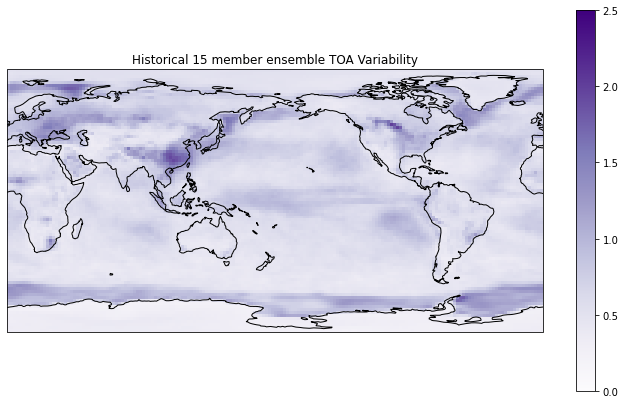

In [46]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
toa_15memens.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=2.5, cmap='Purples')
ax.coastlines(color='black', linewidth=1)
plt.title('Historical 15 member ensemble TOA Variability')

Text(0.5, 1.0, 'Historical 15 member ensemble TOA Variability')

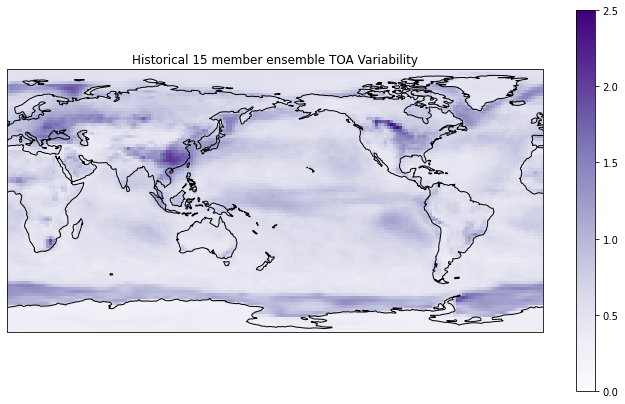

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
toa_15memens.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=2.5, cmap='Purples')
ax.coastlines(color='black', linewidth=1)
plt.title('Historical 15 member ensemble TOA Variability')

# SURFACE FLUXES

# Load Data - Surface Fluxes

In [4]:
# Surface Upward Latent Heat Flux

# path_hfls_control = cat.loc[(cat['variable_id']=='hfls') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()

path_hfls_control = cat.loc[(cat['variable_id']=='hfls') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id')['path'].to_list()

print(path_hfls_control)
print(len(path_hfls_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/h

In [7]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfls_control = []

for file in path_hfls_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfls_rolling = ds.hfls.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfls = ds_hfls_rolling.std('time')
    ds_hfls['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfls_control.append(ds_hfls)

ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfls_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/hfls_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/hfls_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfls_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/hfls_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/hfls_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfls_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfls_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfls_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfls_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/hfls_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [38]:
control_hfls_ds = xr.concat(dset_list_hfls_control, dim='name',coords='minimal', compat='override')
control_hfls = control_hfls_ds.mean('name')
control_hfls.load()

<xarray.DataArray 'hfls' (lat: 88, lon: 179)>
array([[0.02863044, 0.03105451, 0.03029335, ..., 0.0323293 , 0.07787311,
        0.03180823],
       [0.03989603, 0.04902957, 0.04187136, ..., 0.03374822, 0.0314757 ,
        0.03171636],
       [0.08028253, 0.08077865, 0.06635313, ..., 0.03777389, 0.03913928,
        0.03937375],
       ...,
       [0.11783663, 0.12028163, 0.1260084 , ..., 0.1011873 , 0.10036672,
        0.10269125],
       [0.10569864, 0.10104096, 0.10247199, ..., 0.09527503, 0.09634474,
        0.09775964],
       [0.10006807, 0.09685172, 0.09683657, ..., 0.09403271, 0.09470072,
        0.09536479]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [39]:
control_hfls.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_hfls.nc')

In [33]:
# Surface Upward Sensible Heat Flux

# path_hfss_control = cat.loc[(cat['variable_id']=='hfss') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()

path_hfss_control = cat.loc[(cat['variable_id']=='hfss') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(39)['path'].to_list()

print(path_hfss_control)
print(len(path_hfss_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/hfss_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/hfss_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/h

In [10]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfss_control = []

for file in path_hfss_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfss_rolling = ds.hfss.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfss = ds_hfss_rolling.std('time')
    ds_hfss['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfss_control.append(ds_hfss)

ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfss_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfss_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfss_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfss_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfss_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfss_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfss_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/hfss_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/hfss_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/hfss_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfss_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfss_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfss_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfss_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfss_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/hfss_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/hfss_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfss_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfss_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfss_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfss_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfss_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfss_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/hfss_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfss_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfss_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfss_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/hfss_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [36]:
control_hfss_ds = xr.concat(dset_list_hfss_control, dim='name',coords='minimal', compat='override')
control_hfss = control_hfss_ds.mean('name')
control_hfss.load()

<xarray.DataArray 'hfss' (lat: 88, lon: 179)>
array([[0.20728673, 0.2092249 , 0.20677813, ..., 0.21522419, 0.29702841,
        0.206207  ],
       [0.20635324, 0.21702863, 0.19878216, ..., 0.21007938, 0.20768078,
        0.20440436],
       [0.26949603, 0.26114678, 0.23040332, ..., 0.20685132, 0.20539425,
        0.20176761],
       ...,
       [0.28246105, 0.29504777, 0.31284954, ..., 0.25435812, 0.2516691 ,
        0.25466929],
       [0.25472854, 0.25436087, 0.26419216, ..., 0.22985787, 0.23459837,
        0.23871993],
       [0.23955192, 0.23939668, 0.24205278, ..., 0.22905009, 0.23100814,
        0.23394399]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [37]:
control_hfss.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_hfss.nc')

In [34]:
# Surface Downwelling Longwave Flux in Air

# path_rlds_control = cat.loc[(cat['variable_id']=='rlds') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()

path_rlds_control = cat.loc[(cat['variable_id']=='rlds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(39)['path'].to_list()

print(path_rlds_control)
print(len(path_rlds_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [13]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlds_control = []

for file in path_rlds_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlds_rolling = ds.rlds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlds = ds_rlds_rolling.std('time')
    ds_rlds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlds_control.append(ds_rlds)

ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/rlds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rlds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rlds_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rlds_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rlds_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rlds_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rlds_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rlds_Amon_CIESM_piControl_r1i1p1f1_gr_025101-030012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rlds_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/rlds_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rlds_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rlds_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rlds_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rlds_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rlds_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3/piControl/r1i1p1f1/rlds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rlds_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rlds_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rlds_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-070012.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rlds_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rlds_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rlds_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rlds_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rlds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rlds_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rlds_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rlds_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/rlds_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [34]:
control_rlds_ds = xr.concat(dset_list_rlds_control, dim='name',coords='minimal', compat='override')
control_rlds = control_rlds_ds.mean('name')
control_rlds.load()

<xarray.DataArray 'rlds' (lat: 88, lon: 179)>
array([[0.67986451, 0.69706171, 0.69668184, ..., 0.71749565, 0.72027554,
        0.69748154],
       [0.71341223, 0.73801248, 0.73235758, ..., 0.73884604, 0.72735269,
        0.72328612],
       [0.76759951, 0.78039367, 0.76594122, ..., 0.76771028, 0.75056795,
        0.74189763],
       ...,
       [1.91952192, 1.91731432, 1.95765027, ..., 1.72836606, 1.76383641,
        1.80426273],
       [1.78599814, 1.75917384, 1.78272025, ..., 1.68070466, 1.69494933,
        1.71240297],
       [1.66673224, 1.63524917, 1.64527171, ..., 1.60720814, 1.61173501,
        1.61928072]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [35]:
control_rlds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rlds.nc')

In [35]:
# Surface Upwelling Longwave Flux in Air

# path_rlus_control = cat.loc[(cat['variable_id']=='rlus') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()

path_rlus_control = cat.loc[(cat['variable_id']=='rlus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(39)['path'].to_list()

print(path_rlus_control)
print(len(path_rlus_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rlus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rlus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [7]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlus_control = []

for file in path_rlus_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlus_rolling = ds.rlus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlus = ds_rlus_rolling.std('time')
    ds_rlus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlus_control.append(ds_rlus)

ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KeyboardInterrupt: 

In [32]:
control_rlus_ds = xr.concat(dset_list_rlus_control, dim='name',coords='minimal', compat='override')
control_rlus = control_rlus_ds.mean('name')
control_rlus.load()

<xarray.DataArray 'rlus' (lat: 88, lon: 179)>
array([[0.56961098, 0.58060391, 0.57208644, ..., 0.59234229, 0.65509467,
        0.58404805],
       [0.61788812, 0.63478292, 0.62089642, ..., 0.61496078, 0.60752305,
        0.60799274],
       [0.73681256, 0.72173721, 0.69603905, ..., 0.65046221, 0.64628473,
        0.64300478],
       ...,
       [1.86518872, 1.86429512, 1.91115966, ..., 1.62717131, 1.66638225,
        1.71718489],
       [1.71804829, 1.69284741, 1.72083531, ..., 1.58397488, 1.60373956,
        1.62989247],
       [1.61364524, 1.57900136, 1.59023325, ..., 1.54148005, 1.54965906,
        1.55914832]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [33]:
control_rlus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rlus.nc')

In [36]:
# Surface Downwelling Shortwave Flux in Air

# path_rsds_control = cat.loc[(cat['variable_id']=='rsds') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()

path_rsds_control = cat.loc[(cat['variable_id']=='rsds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(39)['path'].to_list()

print(path_rsds_control)
print(len(path_rsds_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [19]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsds_control = []

for file in path_rsds_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsds_rolling = ds.rsds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsds = ds_rsds_rolling.std('time')
    ds_rsds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsds_control.append(ds_rsds)

ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsds_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsds_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsds_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/rsds_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rsds_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rsds_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rsds_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rsds_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rsds_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/rsds_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsds_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsds_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rsds_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsds_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsds_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3-Veg/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/rsds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/rsds_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsds_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsds_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsds_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsds_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsds_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rsds_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rsds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rsds_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rsds_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rsds_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


KACE-1-0-G/piControl/r1i1p1f1/rsds_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [30]:
control_rsds_ds = xr.concat(dset_list_rsds_control, dim='name',coords='minimal', compat='override')
control_rsds = control_rsds_ds.mean('name')
control_rsds.load()

<xarray.DataArray 'rsds' (lat: 88, lon: 179)>
array([[0.42971136, 0.45096056, 0.4608465 , ..., 0.47902456, 0.50018309,
        0.45054095],
       [0.45061654, 0.4956918 , 0.49532139, ..., 0.45703954, 0.44689284,
        0.45161867],
       [0.54136279, 0.57501633, 0.55016358, ..., 0.4627452 , 0.44915448,
        0.45969428],
       ...,
       [0.81371971, 0.84524892, 0.85064075, ..., 0.77429182, 0.7765374 ,
        0.78675414],
       [0.7851869 , 0.79260247, 0.8021109 , ..., 0.77281698, 0.77017686,
        0.77535391],
       [0.76087472, 0.7664073 , 0.76879837, ..., 0.76128626, 0.75923472,
        0.76503149]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [31]:
control_rsds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsds.nc')

In [37]:
# Surface Upwelling Shortwave Flux in Air

# path_rsus_control = cat.loc[(cat['variable_id']=='rsus') &
#                (cat['activity_id']=='CMIP') &
#                (cat['frequency']=='mon') & 
#                (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(43)['path'].to_list()

path_rsus_control = cat.loc[(cat['variable_id']=='rsus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(39)['path'].to_list()

print(path_rsus_control)
print(len(path_rsus_control))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/rsus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/rsus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/r

In [27]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsus_control = []

for file in path_rsus_control:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsus_rolling = ds.rsus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsus = ds_rsus_rolling.std('time')
    ds_rsus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsus_control.append(ds_rsus)

ACCESS-CM2/piControl/r1i1p1f1/rsus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/rsus_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-CM-1-1-MR/piControl/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/rsus_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/rsus_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-060012.nc
CESM2-FV2/piControl/r1i1p1f1/rsus_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/rsus_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/rsus_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/rsus_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/rsus_Amon_CIESM_piControl_r1i1p1f1_gr_000101-050012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/rsus_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CNRM-ESM2-1/piControl/r1i1p1f2/rsus_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/rsus_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/rsus_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/rsus_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/rsus_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/rsus_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3/piControl/r1i1p1f1/rsus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/rsus_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/rsus_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/rsus_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/rsus_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/rsus_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/rsus_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/rsus_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/rsus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/rsus_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/rsus_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/rsus_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


KACE-1-0-G/piControl/r1i1p1f1/rsus_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc


In [28]:
control_rsus_ds = xr.concat(dset_list_rsus_control, dim='name',coords='minimal', compat='override')
control_rsus = control_rsus_ds.mean('name')
control_rsus.load()

<xarray.DataArray 'rsus' (lat: 88, lon: 179)>
array([[0.37258753, 0.39880608, 0.39938448, ..., 0.41968782, 0.6726708 ,
        0.4135963 ],
       [0.44899733, 0.51221834, 0.48579554, ..., 0.41611238, 0.4033487 ,
        0.40545743],
       [0.68208664, 0.69681391, 0.61474775, ..., 0.39331295, 0.39731644,
        0.40082487],
       ...,
       [1.06540021, 1.1320548 , 1.14164119, ..., 0.98260941, 0.9868586 ,
        1.00996436],
       [0.98697119, 0.9958657 , 1.0196526 , ..., 0.94344239, 0.94654156,
        0.95676025],
       [0.93784337, 0.94555682, 0.9489865 , ..., 0.92697648, 0.92977687,
        0.93923956]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [29]:
control_rsus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_rsus.nc')

In [38]:
path_control_surface = path_rsds_control + path_rlds_control + path_hfls_control + path_hfss_control + path_rlus_control + path_rsus_control
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/hfls_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/hfss_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rlds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rlus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsds_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_control_surface.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsus_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')

In [22]:
len(path_control_surface)

222

In [39]:
path_control_surface = sorted(path_control_surface)

In [40]:
path_lists_surface_control = []
for num in range(0,222,6):
    model = []
    model.append(path_control_surface[num])
    model.append(path_control_surface[num+1])
    model.append(path_control_surface[num+2])
    model.append(path_control_surface[num+3])
    model.append(path_control_surface[num+4])
    model.append(path_control_surface[num+5])
    path_lists_surface_control.append(model)

In [41]:
del path_lists_surface_control[3]
indices = np.array([3,4,9,13,14,26,32])
new_path_lists_surface_control = []
for index in indices:
    new_path_lists_surface_control.append(path_lists_surface_control[index])
print(len(new_path_lists_surface_control))
new_path_lists_surface_control

7


[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1

In [42]:
path_GFDL = cat.loc[((cat['activity_id']=='CMIP') &
               (cat['source_id']=='GFDL-CM4') & 
               (cat['experiment_id'].str.contains('Control')))]['path'].to_list()
path_GFDL_new = []
path_GFDL_new.append(path_GFDL[0])
path_GFDL_new.append(path_GFDL[1])
path_GFDL_new.append(path_GFDL[2])
path_GFDL_new.append(path_GFDL[3])
path_GFDL_new.append(path_GFDL[6])
path_GFDL_new.append(path_GFDL[8])
path_GFDL_new = sorted(path_GFDL_new)
path_GFDL_new

['/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/hfls_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/hfss_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rlds_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rlus_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rsds_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-CM4/piControl/r1i1p1f1/rsus_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc']

In [17]:
test_gfdl = xr.open_dataset(path_GFDL_new[0])
test_gfdl

<xarray.Dataset>
Dimensions:   (bnds: 2, time: 6000, lat: 180, lon: 288)
Coordinates:
  * bnds      (bnds) float64 1.0 2.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds  (lat, bnds) float64 ...
  * lon       (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds  (lon, bnds) float64 ...
  * time      (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Data variables:
    hfls      (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    ...                     ...
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/ac4ef276-3380-4a9b-bee8-7c2fe5d49494...
    variable_id:            hfls
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-22;created;by nhn2@columbia.edu

In [43]:
path_GFDL_esm = cat.loc[((cat['activity_id']=='CMIP') &
               (cat['source_id']=='GFDL-ESM4') & 
               (cat['experiment_id'].str.contains('Control')))]['path'].to_list()
path_GFDL_esm_new = []
path_GFDL_esm_new.append(path_GFDL_esm[0])
path_GFDL_esm_new.append(path_GFDL_esm[1])
path_GFDL_esm_new.append(path_GFDL_esm[2])
path_GFDL_esm_new.append(path_GFDL_esm[3])
path_GFDL_esm_new.append(path_GFDL_esm[6])
path_GFDL_esm_new.append(path_GFDL_esm[8])
path_GFDL_esm_new

['/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/hfls_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/hfss_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rlds_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rlus_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rsds_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/GFDL-ESM4/piControl/r1i1p1f1/rsus_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc']

In [19]:
test_gfdl_esm = xr.open_dataset(path_GFDL_esm_new[0])
test_gfdl_esm

<xarray.Dataset>
Dimensions:   (bnds: 2, time: 6000, lat: 180, lon: 288)
Coordinates:
  * bnds      (bnds) float64 1.0 2.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds  (lat, bnds) float64 ...
  * lon       (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds  (lon, bnds) float64 ...
  * time      (time) object 0001-01-16 12:00:00 ... 0500-12-16 12:00:00
Data variables:
    hfls      (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          Coupled climate state after 400 years of spinup, ...
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                <null ref>
    ...                     ...
    table_id:               Amon
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/168a9a98-bbf6-4269-920a-00fd0257f3fa...
    variable_id:            hfls
    variant_info:           N/A
    variant_label:          r1i1p1f1

In [44]:
new_path_lists_surface_control.append(path_GFDL_new)
new_path_lists_surface_control.append(path_GFDL_esm_new)
new_path_lists_surface_control

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1

In [25]:
path_lists_surface_control

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p

In [27]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

dset_list_surface_control = []

for model in path_lists_surface_control:
        name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
        print(name)
        ds_hfls = xr.open_dataset(model[0])
        ds_hfss = xr.open_dataset(model[1])
        ds_rlds = xr.open_dataset(model[2])
        ds_rlus = xr.open_dataset(model[3])
        ds_rsds = xr.open_dataset(model[4])
        ds_rsus = xr.open_dataset(model[5])
        ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
        if len(ds_surface['time'].values)<1800:
            print('Skipping', name)
            continue
        #ds_surface_rolling = ds_surface.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
        #ds_surface_var = ds_surface_rolling.std('time')
        ds_surface_sel = ds_surface.isel(time=slice(300,1800))
        ds_surface_interp = ds_surface_sel.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
        ds_surface_interp['name'] = name
        dset_list_surface_control.append(ds_surface_interp)

ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
Skipping AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfls_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CIESM/piControl/r1i1p1f1/hfls_Amon_CIESM_piControl_r1i1p1f1_gr_000101-05001

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfls_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


FGOALS-f3-L/piControl/r1i1p1f1/hfls_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfls_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfls_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfls_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfls_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piControl

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/m

KACE-1-0-G/piControl/r1i1p1f1/hfls_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc
MIROC-ES2L/piControl/r1i1p1f2/hfls_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MIROC6/piControl/r1i1p1f1/hfls_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-399912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [28]:
CMIP_surface_piControl_interp_extend = xr.concat(dset_list_surface_control, dim='name', coords='minimal', compat='override')
CMIP_surface_piControl_interp_extend.load()

<xarray.DataArray (name: 35, time: 1500, lat: 88, lon: 179)>
array([[[[ 2.88063995e+00,  2.95051758e+00,  3.06557007e+00, ...,
           2.56959890e+00,  2.63902232e+00,  2.71155914e+00],
         [ 2.40066935e+00,  2.49718628e+00,  2.55001068e+00, ...,
           2.21357422e+00,  2.24427795e+00,  2.29887390e+00],
         [ 2.23351227e+00,  2.30423279e+00,  2.37017568e+00, ...,
           1.98701782e+00,  2.03715057e+00,  2.09301575e+00],
         ...,
         [-2.83961648e+01, -2.86732227e+01, -2.89271922e+01, ...,
          -2.59437050e+01, -2.60000743e+01, -2.65590720e+01],
         [-2.65713923e+01, -2.66039093e+01, -2.66674042e+01, ...,
          -2.55128123e+01, -2.57604752e+01, -2.60688797e+01],
         [-2.61302083e+01, -2.63181937e+01, -2.63360616e+01, ...,
          -2.52876338e+01, -2.56218541e+01, -2.57333725e+01]],

        [[ 1.01998510e+00,  1.05224457e+00,  1.03554230e+00, ...,
           9.00537211e-01,  9.44435374e-01,  9.67861786e-01],
         [ 7.08449809e-01,  7.17607880e-01,  7.42666880e-01, ...,
           7.17484792e-01,  6.99686686e-01,  6.82359314e-01],
         [ 7.02204336e-01,  7.02977600e-01,  7.10463206e-01, ...,
           6.78542531e-01,  6.85071564e-01,  6.96911621e-01],
...
         [-2.50353169e+01, -2.47533463e+01, -2.45846367e+01, ...,
          -2.52807203e+01, -2.53468342e+01, -2.53292456e+01],
         [-2.31533042e+01, -2.28097966e+01, -2.25324498e+01, ...,
          -2.43525806e+01, -2.40602809e+01, -2.38091798e+01],
         [-2.34808161e+01, -2.33337312e+01, -2.31826686e+01, ...,
          -2.40376157e+01, -2.38421191e+01, -2.37131087e+01]],

        [[ 6.64223286e+00,  6.63043802e+00,  6.61858480e+00, ...,
           6.71494298e+00,  6.68029145e+00,  6.66807255e+00],
         [ 6.58536109e+00,  6.60743160e+00,  6.63336702e+00, ...,
           6.38207823e+00,  6.42786120e+00,  6.48735627e+00],
         [ 7.26861387e+00,  7.32133116e+00,  7.34565378e+00, ...,
           6.97265282e+00,  7.05596034e+00,  7.13681806e+00],
         ...,
         [-3.28731287e+01, -3.29302508e+01, -3.31070174e+01, ...,
          -3.07692891e+01, -3.16458422e+01, -3.23234283e+01],
         [-2.87313388e+01, -2.86505481e+01, -2.85819349e+01, ...,
          -2.90584848e+01, -2.89669435e+01, -2.88394701e+01],
         [-2.80063209e+01, -2.79383759e+01, -2.78875932e+01, ...,
          -2.81984081e+01, -2.81524221e+01, -2.81400488e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U103 'ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2...

In [29]:
CMIP_surface_piControl_interp_extend.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_piControl_interp_extend.nc')

In [28]:
test_hfls = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_hfss = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rlds = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rlus = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rsds = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
test_rsus = xr.open_dataset('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

In [17]:
test_surface = test_rlds.rlds + test_rsds.rsds - test_hfss.hfss - test_hfls.hfls - test_rsus.rsus - test_rlus.rlus

NameError: name 'test_rlds' is not defined

In [22]:
CMIP_surface_piControl_interp = xr.concat(dset_list_surface_control, dim='name', coords='minimal', compat='override')
CMIP_surface_piControl_interp.load()

<xarray.DataArray (name: 9, time: 1500, lat: 88, lon: 179)>
array([[[[ 3.39850302e+00,  3.41417246e+00,  3.45564645e+00, ...,
           3.26545729e+00,  3.27783883e+00,  3.32447948e+00],
         [ 3.28054698e+00,  3.29991967e+00,  3.30187870e+00, ...,
           3.25308862e+00,  3.28090054e+00,  3.26411404e+00],
         [ 4.05409673e+00,  3.99146260e+00,  3.91367162e+00, ...,
           3.93799453e+00,  4.09078838e+00,  4.11297579e+00],
         ...,
         [-3.03136781e+01, -3.01690631e+01, -3.05290376e+01, ...,
          -2.71065312e+01, -2.80005614e+01, -2.87211936e+01],
         [-2.87204652e+01, -2.92860922e+01, -3.01703797e+01, ...,
          -2.72294478e+01, -2.71159994e+01, -2.71639947e+01],
         [-2.64169938e+01, -2.61577167e+01, -2.62717127e+01, ...,
          -2.78791483e+01, -2.70144323e+01, -2.70226429e+01]],

        [[-1.77046449e+00, -1.78380866e+00, -1.86195850e+00, ...,
          -1.55690938e+00, -1.58058143e+00, -1.65905673e+00],
         [-1.73856327e+00, -1.82117826e+00, -1.87870931e+00, ...,
          -1.56793132e+00, -1.63132377e+00, -1.64435299e+00],
         [-2.35685349e+00, -2.30634801e+00, -2.31745261e+00, ...,
          -2.10030796e+00, -2.23765094e+00, -2.31238928e+00],
...
         [-4.12004921e+01, -4.16000320e+01, -4.08972321e+01, ...,
          -3.67821884e+01, -3.76696243e+01, -3.85909019e+01],
         [-3.76136894e+01, -3.83689163e+01, -3.89362183e+01, ...,
          -3.68359726e+01, -3.70287552e+01, -3.72182953e+01],
         [-3.60778816e+01, -3.60573830e+01, -3.60510521e+01, ...,
          -3.61414474e+01, -3.61282425e+01, -3.61133522e+01]],

        [[ 1.06452133e+01,  1.06054977e+01,  1.05820847e+01, ...,
           1.07948074e+01,  1.07587433e+01,  1.07218307e+01],
         [ 1.02828903e+01,  1.06112442e+01,  1.07531891e+01, ...,
           1.00353378e+01,  1.00266724e+01,  1.00183624e+01],
         [ 9.98862762e+00,  9.73443909e+00,  9.64264679e+00, ...,
           9.84324188e+00,  9.39447021e+00,  9.01401978e+00],
         ...,
         [-4.65505783e+01, -4.73075455e+01, -4.80323677e+01, ...,
          -3.93636360e+01, -4.12918701e+01, -4.32426682e+01],
         [-3.88982155e+01, -3.87834625e+01, -3.88026314e+01, ...,
          -3.73384537e+01, -3.78218536e+01, -3.82949722e+01],
         [-3.69558975e+01, -3.69983612e+01, -3.70232773e+01, ...,
          -3.67733414e+01, -3.68208046e+01, -3.68671371e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U95 'BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-M...

In [23]:
CMIP_surface_piControl_interp.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_piControl_interp.nc')

In [18]:
control_surface_ds = xr.concat(dset_list_surface_control, dim='name', coords='minimal', compat='override')
control_surface = control_surface_ds.mean('name')
control_surface.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.02626577, 0.02549466, 0.02530642, ..., 0.02486013, 0.02580296,
        0.02535174],
       [0.02927196, 0.0267958 , 0.02700674, ..., 0.02985472, 0.02931223,
        0.02890721],
       [0.03050431, 0.02870428, 0.02841127, ..., 0.02873226, 0.02879971,
        0.02867641],
       ...,
       [0.53121883, 0.53576833, 0.54262427, ..., 0.51056325, 0.50033145,
        0.49970719],
       [0.49266813, 0.48254617, 0.48812566, ..., 0.46460795, 0.46616764,
        0.46588058],
       [0.47413203, 0.46970089, 0.47021227, ..., 0.4564307 , 0.45886739,
        0.46164606]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [19]:
control_surface.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_surface.nc')

# Historical Surface Fluxes

In [23]:
# Surface Upward Latent Heat Flux

path_hfls_hist = cat.loc[(cat['variable_id']=='hfls') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()
print(path_hfls_hist)
print(len(path_hfls_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [71]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfls_hist = []

for file in path_hfls_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfls_rolling = ds.hfls.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfls = ds_hfls_rolling.std('time')
    ds_hfls['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfls_hist.append(ds_hfls)

ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfls_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfls_Amon_CESM2-WA

In [72]:
hist_hfls_ds = xr.concat(dset_list_hfls_hist, dim='name',coords='minimal', compat='override')
hist_hfls = hist_hfls_ds.mean('name')
hist_hfls.load()

<xarray.DataArray 'hfls' (lat: 88, lon: 179)>
array([[0.0388473 , 0.03728555, 0.0370926 , ..., 0.04470199, 0.03260226,
        0.03398409],
       [0.03259672, 0.03432878, 0.03285321, ..., 0.03224032, 0.03284059,
        0.0326788 ],
       [0.07870734, 0.08728231, 0.0501024 , ..., 0.03765061, 0.03839766,
        0.03845851],
       ...,
       [0.14533961, 0.15324345, 0.1630115 , ..., 0.12212601, 0.12516091,
        0.12886154],
       [0.13535697, 0.13345734, 0.13499989, ..., 0.12642855, 0.12715366,
        0.12889892],
       [0.13050449, 0.12715461, 0.12802405, ..., 0.12396352, 0.12456197,
        0.12571374]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [73]:
hist_hfls.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_hfls.nc')

In [24]:
# Surface Upward Sensible Heat Flux

path_hfss_hist = cat.loc[(cat['variable_id']=='hfss') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()
print(path_hfss_hist)
print(len(path_hfss_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/hfss_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/hfss_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [75]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hfss_hist = []

for file in path_hfss_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_hfss_rolling = ds.hfss.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_hfss = ds_hfss_rolling.std('time')
    ds_hfss['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hfss_hist.append(ds_hfss)

ACCESS-CM2/historical/r1i1p1f1/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfss_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfss_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfss_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfss_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfss_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfss_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfss_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfss_Amon_CESM2-WA

In [76]:
hist_hfss_ds = xr.concat(dset_list_hfss_hist, dim='name',coords='minimal', compat='override')
hist_hfss = hist_hfss_ds.mean('name')
hist_hfss.load()

<xarray.DataArray 'hfss' (lat: 88, lon: 179)>
array([[0.21632026, 0.23010293, 0.22936909, ..., 0.24838959, 0.23006386,
        0.22946768],
       [0.20548987, 0.20884948, 0.20728587, ..., 0.21920015, 0.2167511 ,
        0.21556934],
       [0.26387342, 0.27958429, 0.21437134, ..., 0.21496556, 0.21207239,
        0.20848142],
       ...,
       [0.31217637, 0.3389299 , 0.35946384, ..., 0.27990681, 0.28699579,
        0.29309778],
       [0.30664277, 0.30690316, 0.31403887, ..., 0.29313474, 0.29795398,
        0.30125191],
       [0.29136788, 0.29238886, 0.29515907, ..., 0.28694374, 0.28674367,
        0.2875656 ]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [77]:
hist_hfss.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_hfss.nc')

In [25]:
# Surface Downwelling Longwave Flux in air

path_rlds_hist = cat.loc[(cat['variable_id']=='rlds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()
print(path_rlds_hist)
print(len(path_rlds_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [79]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlds_hist = []

for file in path_rlds_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlds_rolling = ds.rlds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlds = ds_rlds_rolling.std('time')
    ds_rlds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlds_hist.append(ds_rlds)

ACCESS-CM2/historical/r1i1p1f1/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlds_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlds_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlds_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlds_Amon_CESM2-WA

In [80]:
hist_rlds_ds = xr.concat(dset_list_rlds_hist, dim='name',coords='minimal', compat='override')
hist_rlds = hist_rlds_ds.mean('name')
hist_rlds.load()

<xarray.DataArray 'rlds' (lat: 88, lon: 179)>
array([[1.12941634, 1.15516751, 1.15105999, ..., 1.17073001, 1.16368365,
        1.1619688 ],
       [1.11479326, 1.13541771, 1.12601482, ..., 1.15487863, 1.15249597,
        1.14562488],
       [1.1583244 , 1.18256217, 1.15248988, ..., 1.17201765, 1.16764712,
        1.16077755],
       ...,
       [3.23148512, 3.21299442, 3.25179055, ..., 3.03162628, 3.0652348 ,
        3.09954268],
       [3.14455207, 3.10108877, 3.12410392, ..., 3.01315792, 3.02939417,
        3.0489258 ],
       [3.07982201, 3.01626444, 3.01949677, ..., 2.98862211, 2.99281092,
        3.00019805]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [81]:
hist_rlds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rlds.nc')

In [26]:
# Surface Upwelling Longwave Flux in Air

path_rlus_hist = cat.loc[(cat['variable_id']=='rlus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()
print(path_rlus_hist)
print(len(path_rlus_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rlus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rlus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [83]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rlus_hist = []

for file in path_rlus_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rlus_rolling = ds.rlus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rlus = ds_rlus_rolling.std('time')
    ds_rlus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rlus_hist.append(ds_rlus)

ACCESS-CM2/historical/r1i1p1f1/rlus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rlus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rlus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rlus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rlus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rlus_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rlus_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rlus_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rlus_Amon_CESM2-WA

In [84]:
hist_rlus_ds = xr.concat(dset_list_rlus_hist, dim='name',coords='minimal', compat='override')
hist_rlus = hist_rlus_ds.mean('name')
hist_rlus.load()

<xarray.DataArray 'rlus' (lat: 88, lon: 179)>
array([[0.93947185, 0.95317274, 0.94962887, ..., 0.96995195, 0.9502316 ,
        0.94987047],
       [0.94116405, 0.95984619, 0.96125746, ..., 0.94614177, 0.94636908,
        0.95151278],
       [1.03763339, 1.06103183, 1.00922045, ..., 0.99262583, 0.98774887,
        0.98473338],
       ...,
       [2.78569527, 2.777638  , 2.81792358, ..., 2.58302436, 2.61381498,
        2.65396442],
       [2.67180451, 2.63410405, 2.65357271, ..., 2.55644788, 2.56971699,
        2.5894959 ],
       [2.57981831, 2.53156325, 2.53591042, ..., 2.51226346, 2.51661657,
        2.52251301]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [85]:
hist_rlus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rlus.nc')

In [27]:
# Surface Downwelling Shortwave Flux in Air

path_rsds_hist = cat.loc[(cat['variable_id']=='rsds') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()
print(path_rsds_hist)
print(len(path_rsds_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [87]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsds_hist = []

for file in path_rsds_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsds_rolling = ds.rsds.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsds = ds_rsds_rolling.std('time')
    ds_rsds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsds_hist.append(ds_rsds)

ACCESS-CM2/historical/r1i1p1f1/rsds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsds_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsds_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsds_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsds_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsds_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsds_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsds_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsds_Amon_CESM2-WA

In [88]:
hist_rsds_ds = xr.concat(dset_list_rsds_hist, dim='name',coords='minimal', compat='override')
hist_rsds = hist_rsds_ds.mean('name')
hist_rsds.load()

<xarray.DataArray 'rsds' (lat: 88, lon: 179)>
array([[0.43762062, 0.44693225, 0.44456779, ..., 0.45575659, 0.44369105,
        0.44366753],
       [0.4331804 , 0.45960711, 0.45541847, ..., 0.44215507, 0.44234963,
        0.44470036],
       [0.55837221, 0.60831992, 0.52435322, ..., 0.48681663, 0.46726301,
        0.45962771],
       ...,
       [1.49995919, 1.53671198, 1.54636002, ..., 1.39456549, 1.43135005,
        1.45904155],
       [1.44876252, 1.46340199, 1.48391488, ..., 1.41112365, 1.4219399 ,
        1.43245385],
       [1.41751128, 1.42614471, 1.43322458, ..., 1.39650474, 1.39998916,
        1.40240066]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [89]:
hist_rsds.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsds.nc')

In [28]:
# Surface Upwelling Shortwave Flux in Air

path_rsus_hist = cat.loc[(cat['variable_id']=='rsus') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id')['path'].to_list()
print(path_rsus_hist)
print(len(path_rsus_hist))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/rsus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/rsus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [91]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_rsus_hist = []

for file in path_rsus_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_rsus_rolling = ds.rsus.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_rsus = ds_rsus_rolling.std('time')
    ds_rsus['name'] = name # Creating a new dimension for each ensemble member
    dset_list_rsus_hist.append(ds_rsus)

ACCESS-CM2/historical/r1i1p1f1/rsus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/rsus_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/rsus_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/rsus_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/rsus_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/rsus_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/rsus_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/rsus_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/rsus_Amon_CESM2-WA

In [92]:
hist_rsus_ds = xr.concat(dset_list_rsus_hist, dim='name',coords='minimal', compat='override')
hist_rsus = hist_rsus_ds.mean('name')
hist_rsus.load()

<xarray.DataArray 'rsus' (lat: 88, lon: 179)>
array([[0.40602414, 0.41116871, 0.4153252 , ..., 0.45819867, 0.37840247,
        0.38151113],
       [0.39055131, 0.42331459, 0.42045009, ..., 0.3810477 , 0.3897252 ,
        0.38828737],
       [0.67443255, 0.74636114, 0.5236131 , ..., 0.39232533, 0.3895297 ,
        0.38729527],
       ...,
       [1.84114975, 1.90313374, 1.9286584 , ..., 1.69583893, 1.74053637,
        1.78666932],
       [1.71582629, 1.74360622, 1.77794026, ..., 1.66538807, 1.67964454,
        1.69355777],
       [1.65683566, 1.68613548, 1.69769244, ..., 1.65106576, 1.65679316,
        1.65990531]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [93]:
hist_rsus.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_rsus.nc')

In [29]:
path_surface_hist = path_rsds_hist + path_rlds_hist + path_hfls_hist + path_hfss_hist + path_rlus_hist + path_rsus_hist

path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/hfls_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/hfss_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rlds_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rlus_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsds_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsus_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
# path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/hfls_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
# path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/hfss_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
# path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rlds_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
# path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rlus_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
# path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsds_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
# path_surface_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsus_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')

In [30]:
print(len(path_surface_hist))

288


In [31]:
path_surface_hist = sorted(path_surface_hist)

In [32]:
path_lists_surface_hist = []
for num in range(0,288,6):
    model = []
    model.append(path_surface_hist[num])
    model.append(path_surface_hist[num+1])
    model.append(path_surface_hist[num+2])
    model.append(path_surface_hist[num+3])
    model.append(path_surface_hist[num+4])
    model.append(path_surface_hist[num+5])
    path_lists_surface_hist.append(model)
path_lists_surface_hist

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5

In [13]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

dset_list_surface_hist = []
i = 0

for model in path_lists_surface_hist:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rsds = xr.open_dataset(model[4])
    ds_rsus = xr.open_dataset(model[5])
    if i == 6:
        ds_hfls.load()
        ds_hfss.load()
        ds_rlds.load()
        ds_rlus.load()
        ds_rsds.load()
        ds_rsus.load()
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_surface_sel = ds_surface.isel(time=slice(300,1800))
    ds_surface_interp = ds_surface_sel.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_surface_interp['name'] = name
    dset_list_surface_hist.append(ds_surface_interp)
    i += 1

ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfls_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfls_Amon_CESM2-WA

In [14]:
CMIP_surface_hist_interp_extend = xr.concat(dset_list_surface_hist, dim='name', coords='minimal', compat='override')
CMIP_surface_hist_interp_extend.load()

<xarray.DataArray (name: 37, time: 1500, lat: 88, lon: 179)>
array([[[[ 2.96426951e+00,  3.03861237e+00,  3.08949076e+00, ...,
           2.62298747e+00,  2.75441132e+00,  2.94239532e+00],
         [ 2.50811768e+00,  2.58842010e+00,  2.64185079e+00, ...,
           2.40234934e+00,  2.36455536e+00,  2.42947845e+00],
         [ 2.55737457e+00,  2.58824554e+00,  2.66041209e+00, ...,
           2.19597707e+00,  2.40121663e+00,  2.45222198e+00],
         ...,
         [-2.83570973e+01, -2.85479318e+01, -2.93209447e+01, ...,
          -2.75680020e+01, -2.75787292e+01, -2.75105643e+01],
         [-2.56614049e+01, -2.58462341e+01, -2.57682419e+01, ...,
          -2.60634562e+01, -2.59596278e+01, -2.55441940e+01],
         [-2.28188145e+01, -2.28951208e+01, -2.30574753e+01, ...,
          -2.36636237e+01, -2.38427144e+01, -2.36334088e+01]],

        [[ 8.24896037e-01,  8.45366516e-01,  8.68745931e-01, ...,
           7.06485443e-01,  7.41632080e-01,  7.63038330e-01],
         [ 4.83799998e-01,  5.01479340e-01,  5.24042765e-01, ...,
           3.79169210e-01,  4.37899272e-01,  4.67372131e-01],
         [ 2.47966919e-01,  3.20337982e-01,  3.31244659e-01, ...,
           3.29175975e-01,  1.71749878e-01,  1.80291748e-01],
...
         [-3.76944404e+01, -3.79277468e+01, -3.80162133e+01, ...,
          -3.36232007e+01, -3.51772640e+01, -3.63835890e+01],
         [-3.20709987e+01, -3.19984888e+01, -3.18911084e+01, ...,
          -3.23325205e+01, -3.23468977e+01, -3.22542003e+01],
         [-3.08165854e+01, -3.06420025e+01, -3.04542676e+01, ...,
          -3.12894040e+01, -3.12050887e+01, -3.11442398e+01]],

        [[ 7.02745039e+00,  6.99881249e+00,  6.96284663e+00, ...,
           7.12241836e+00,  7.10375419e+00,  7.07929505e+00],
         [ 7.50776314e+00,  7.55489714e+00,  7.61901729e+00, ...,
           7.25258678e+00,  7.28705374e+00,  7.38148205e+00],
         [ 7.78745604e+00,  7.81228475e+00,  7.86249910e+00, ...,
           8.01012992e+00,  7.90705651e+00,  7.85199689e+00],
         ...,
         [-3.46985878e+01, -3.48455910e+01, -3.52763595e+01, ...,
          -3.46673413e+01, -3.52390107e+01, -3.50575260e+01],
         [-3.32266116e+01, -3.29588246e+01, -3.27542013e+01, ...,
          -3.44387398e+01, -3.43461211e+01, -3.40288356e+01],
         [-3.41518068e+01, -3.40451804e+01, -3.39524495e+01, ...,
          -3.46158328e+01, -3.45065234e+01, -3.44131899e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U105 'ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM...

In [15]:
CMIP_surface_hist_interp_extend.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp_extend.nc')

In [89]:
CMIP_surface_hist_interp = xr.concat(dset_lists_surface_hist, dim='name', coords='minimal', compat='override')
CMIP_surface_hist_interp.load()

<xarray.DataArray (name: 9, time: 1500, lat: 88, lon: 179)>
array([[[[ 4.90165056e+00,  5.02030481e+00,  5.14833517e+00, ...,
           4.42925605e+00,  4.56485558e+00,  4.66646627e+00],
         [ 4.59733384e+00,  4.82168076e+00,  4.98723783e+00, ...,
           3.81284670e+00,  3.96564983e+00,  4.19904078e+00],
         [ 4.02822119e+00,  4.18452456e+00,  4.37871187e+00, ...,
           3.16195200e+00,  3.32776068e+00,  3.54453707e+00],
         ...,
         [-3.46124473e+01, -3.68575683e+01, -3.48434307e+01, ...,
          -3.44554857e+01, -3.57958553e+01, -3.51358641e+01],
         [-3.32735436e+01, -3.38893754e+01, -3.38385741e+01, ...,
          -3.26756667e+01, -3.27437460e+01, -3.27906597e+01],
         [-3.46177860e+01, -3.51192427e+01, -3.58445793e+01, ...,
          -3.36690564e+01, -3.51623532e+01, -3.55597275e+01]],

        [[-2.86197465e+00, -2.93874279e+00, -3.03927916e+00, ...,
          -2.56575976e+00, -2.67832265e+00, -2.74031600e+00],
         [-2.12785747e+00, -2.32005957e+00, -2.40554916e+00, ...,
          -1.76238901e+00, -1.80849465e+00, -1.92474648e+00],
         [-1.41721594e+00, -1.48068312e+00, -1.55627523e+00, ...,
          -9.75113796e-01, -1.02866159e+00, -1.15787975e+00],
...
         [-4.22657914e+01, -4.27121239e+01, -4.25050988e+01, ...,
          -4.14794275e+01, -4.14537856e+01, -4.16859040e+01],
         [-4.16607946e+01, -4.18207167e+01, -4.15129903e+01, ...,
          -4.08408854e+01, -4.07483856e+01, -4.08952654e+01],
         [-4.09747304e+01, -4.15050773e+01, -4.12692748e+01, ...,
          -3.93983996e+01, -3.99012588e+01, -4.01739465e+01]],

        [[ 3.72216024e+00,  3.72758932e+00,  3.73674215e+00, ...,
           3.69827086e+00,  3.70587259e+00,  3.71236349e+00],
         [ 3.78478374e+00,  3.80151044e+00,  3.80537598e+00, ...,
           3.69636811e+00,  3.71102061e+00,  3.73913749e+00],
         [ 3.62171032e+00,  3.63325908e+00,  3.67212569e+00, ...,
           3.65140738e+00,  3.64544715e+00,  3.62874548e+00],
         ...,
         [-2.50812586e+01, -2.53460143e+01, -2.53195316e+01, ...,
          -2.65939754e+01, -2.71630297e+01, -2.63456181e+01],
         [-2.66460704e+01, -2.65967282e+01, -2.59333669e+01, ...,
          -2.72300927e+01, -2.67794278e+01, -2.68775401e+01],
         [-2.90347791e+01, -2.92975723e+01, -2.93255644e+01, ...,
          -2.95780620e+01, -3.00762300e+01, -3.00066347e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U97 'BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-...

In [90]:
CMIP_surface_hist_interp.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp.nc')

In [28]:
hist_surface_ds = xr.concat(dset_list_surface_hist, dim='name', coords='minimal', compat='override')
hist_surface = hist_surface_ds.mean('name')
hist_surface.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.03895062, 0.03738389, 0.03888683, ..., 0.03866019, 0.03580975,
        0.03609229],
       [0.04336203, 0.04217144, 0.04178755, ..., 0.03930641, 0.03930131,
        0.03998676],
       [0.05062516, 0.0467887 , 0.04513291, ..., 0.04631184, 0.0457027 ,
        0.04514673],
       ...,
       [0.75116097, 0.75074171, 0.76393557, ..., 0.72158533, 0.71409527,
        0.71650202],
       [0.68055328, 0.67309338, 0.68671087, ..., 0.65128629, 0.65358977,
        0.65489889],
       [0.67592168, 0.66818446, 0.67442065, ..., 0.6533955 , 0.6556554 ,
        0.65665822]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [29]:
hist_surface.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_surface.nc')

# 15 Model Ensemble - Hist. Surface Fluxes

In [35]:
indices = np.array([4,5,11,14,15,16,17,22,26,28,30,34,38,47])
new_path_lists_surface_hist = []
for index in indices:
    new_path_lists_surface_hist.append(path_lists_surface_hist[index])
print(len(new_path_lists_surface_hist))
new_path_lists_surface_hist

14


[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/hist

In [36]:
path_NESM_hfls = df.query("activity_id=='CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'hfls' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
path_NESM_hfss = df.query("activity_id=='CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'hfss' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
path_NESM_rlds = df.query("activity_id=='CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'rlds' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
path_NESM_rlus = df.query("activity_id=='CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'rlus' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
path_NESM_rsds = df.query("activity_id=='CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'rsds' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
path_NESM_rsus = df.query("activity_id=='CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'rsus' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")

path_NESM_list = [path_NESM_hfls, path_NESM_hfss, path_NESM_rlds, path_NESM_rlus, path_NESM_rsds, path_NESM_rsus]
len(path_NESM_list)

6

In [37]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #150 years
new_time_index
   
zstore = path_NESM_list[0].zstore.values[0]
# make a nice concise name from the zstore value
name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
name = zstore.split('gs://cmip6/CMIP6/CMIP/')[1].replace('/','.')[:-1]
name_list = name.split('.')
name = name_list[1]

mapper = gcs.get_mapper(zstore)
NESM_hfls = xr.open_zarr(mapper,consolidated=True)

zstore = path_NESM_list[1].zstore.values[0]
mapper = gcs.get_mapper(zstore)
NESM_hfss = xr.open_zarr(mapper,consolidated=True)

zstore = path_NESM_list[2].zstore.values[0]
mapper = gcs.get_mapper(zstore)
NESM_rlds = xr.open_zarr(mapper,consolidated=True)

zstore = path_NESM_list[3].zstore.values[0]
mapper = gcs.get_mapper(zstore)
NESM_rlus = xr.open_zarr(mapper,consolidated=True)

zstore = path_NESM_list[4].zstore.values[0]
mapper = gcs.get_mapper(zstore)
NESM_rsds = xr.open_zarr(mapper,consolidated=True)

zstore = path_NESM_list[5].zstore.values[0]
mapper = gcs.get_mapper(zstore)
NESM_rsus = xr.open_zarr(mapper,consolidated=True)

NESM_surface = NESM_rsds.rsds + NESM_rlds.rlds - NESM_hfls.hfls - NESM_hfss.hfss - NESM_rlus.rlus - NESM_rsus.rsus
NESM_surface_sel = NESM_surface.isel(time=slice(300,1800))
NESM_surface_interp = NESM_surface_sel.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
NESM_surface_interp['name'] = name

In [38]:
NESM_surface_interp

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U5 'NESM3'

In [39]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years
new_time_index

dset_lists_surface_hist = []
i = 0

for model in new_path_lists_surface_hist:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    name, mid, tail = name.partition('/historical/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rsds = xr.open_dataset(model[4])
    ds_rsus = xr.open_dataset(model[5])
    #if i == 6:
        #ds_hfls.load()
        #ds_hfss.load()
        #ds_rlds.load()
        #ds_rlus.load()
        #ds_rsds.load()
        #ds_rsus.load()
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_surface_sel = ds_surface.isel(time=slice(300,1800))
    ds_surface_interp = ds_surface_sel.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_surface_interp['name'] = name
    dset_lists_surface_hist.append(ds_surface_interp)
    i += 1

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
UKESM1-0-LL


In [40]:
dset_lists_surface_hist.append(NESM_surface_interp)
print(dset_lists_surface_hist)

[<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[  4.90165056,   5.02030481,   5.14833517, ...,   4.42925605,
           4.56485558,   4.66646627],
        [  4.59733384,   4.82168076,   4.98723783, ...,   3.8128467 ,
           3.96564983,   4.19904078],
        [  4.02822119,   4.18452456,   4.37871187, ...,   3.161952  ,
           3.32776068,   3.54453707],
        ...,
        [-34.61244727, -36.85756833, -34.84343068, ..., -34.4554857 ,
         -35.79585531, -35.13586408],
        [-33.27354359, -33.8893754 , -33.83857412, ..., -32.67566665,
         -32.74374599, -32.7906597 ],
        [-34.61778596, -35.1192427 , -35.84457935, ..., -33.66905639,
         -35.16235318, -35.5597275 ]],

       [[ -2.86197465,  -2.93874279,  -3.03927916, ...,  -2.56575976,
          -2.67832265,  -2.740316  ],
        [ -2.12785747,  -2.32005957,  -2.40554916, ...,  -1.76238901,
          -1.80849465,  -1.92474648],
        [ -1.41721594,  -1.48068312,  -1.55627523, ...,  -0.9751138 ,

In [41]:
CMIP_surface_hist_interp_15memens = xr.concat(dset_lists_surface_hist, dim='name', coords='minimal', compat='override')
CMIP_surface_hist_interp_15memens.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ 4.90165056e+00,  5.02030481e+00,  5.14833517e+00, ...,
           4.42925605e+00,  4.56485558e+00,  4.66646627e+00],
         [ 4.59733384e+00,  4.82168076e+00,  4.98723783e+00, ...,
           3.81284670e+00,  3.96564983e+00,  4.19904078e+00],
         [ 4.02822119e+00,  4.18452456e+00,  4.37871187e+00, ...,
           3.16195200e+00,  3.32776068e+00,  3.54453707e+00],
         ...,
         [-3.46124473e+01, -3.68575683e+01, -3.48434307e+01, ...,
          -3.44554857e+01, -3.57958553e+01, -3.51358641e+01],
         [-3.32735436e+01, -3.38893754e+01, -3.38385741e+01, ...,
          -3.26756667e+01, -3.27437460e+01, -3.27906597e+01],
         [-3.46177860e+01, -3.51192427e+01, -3.58445793e+01, ...,
          -3.36690564e+01, -3.51623532e+01, -3.55597275e+01]],

        [[-2.86197465e+00, -2.93874279e+00, -3.03927916e+00, ...,
          -2.56575976e+00, -2.67832265e+00, -2.74031600e+00],
         [-2.12785747e+00, -2.32005957e+00, -2.40554916e+00, ...,
          -1.76238901e+00, -1.80849465e+00, -1.92474648e+00],
         [-1.41721594e+00, -1.48068312e+00, -1.55627523e+00, ...,
          -9.75113796e-01, -1.02866159e+00, -1.15787975e+00],
...
         [-2.78088935e+01, -2.78776526e+01, -2.93542580e+01, ...,
          -1.90225108e+01, -1.93425562e+01, -2.20628261e+01],
         [-2.44885393e+01, -2.53342339e+01, -2.67468318e+01, ...,
          -1.73685251e+01, -2.00562108e+01, -2.04017211e+01],
         [-2.17705019e+01, -2.34594400e+01, -2.61322040e+01, ...,
          -2.20741132e+01, -2.23441102e+01, -2.22555440e+01]],

        [[ 2.00020313e+01,  2.02547712e+01,  2.04408099e+01, ...,
           1.97594779e+01,  1.98033927e+01,  1.99940870e+01],
         [ 1.87190357e+01,  1.87650739e+01,  1.88504934e+01, ...,
           1.84766899e+01,  1.86177975e+01,  1.85550708e+01],
         [ 1.79714223e+01,  1.81370286e+01,  1.83174774e+01, ...,
           1.72408851e+01,  1.75626934e+01,  1.76884266e+01],
         ...,
         [-3.28068227e+01, -3.18609009e+01, -3.11594645e+01, ...,
          -2.05865988e+01, -2.25901160e+01, -2.73886632e+01],
         [-2.14137497e+01, -2.32414394e+01, -2.30369152e+01, ...,
          -1.75088925e+01, -1.97793967e+01, -2.07191078e+01],
         [-2.20522095e+01, -2.36049736e+01, -2.36618611e+01, ...,
          -2.03961387e+01, -2.12793080e+01, -2.13185888e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL' 'NESM3'

In [35]:
CMIP_surface_hist_interp_15memens.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp_15memens.nc')

In [42]:
CMIP_surface_hist_interp_15memens.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp_15memens_2.nc')

In [43]:
surface_15memens = CMIP_surface_hist_interp_15memens.rolling(time=300, center=True).mean('time')
surface_15memens = surface_15memens.std('time')
surface_15memens = surface_15memens.mean('name')

Text(0.5, 1.0, 'Historical 15 member ensemble Qs Variability')

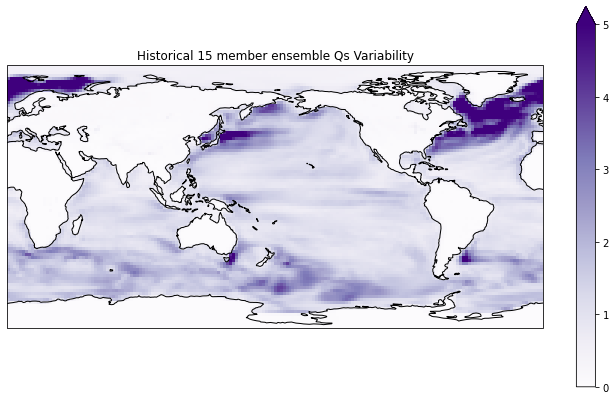

In [44]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
surface_15memens.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=5, cmap='Purples')
ax.coastlines(color='black', linewidth=1)
plt.title('Historical 15 member ensemble Qs Variability')

Text(0.5, 1.0, 'Historical 15 member ensemble Qs Variability')

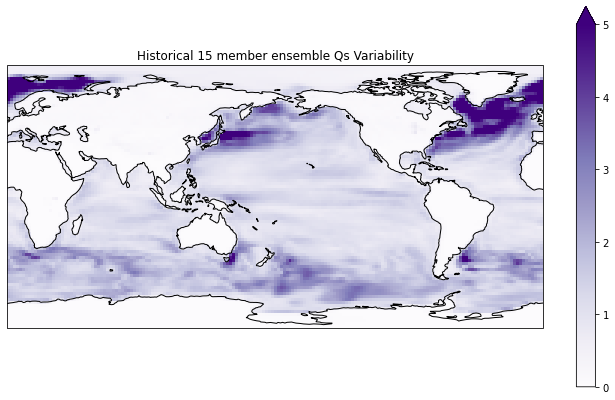

In [42]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
surface_15memens.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=5, cmap='Purples')
ax.coastlines(color='black', linewidth=1)
plt.title('Historical 15 member ensemble Qs Variability')

# Horizontal Motion

In [15]:
path_horiz_control = path_control_surface + path_toa_control

path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/hfss_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rlus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsds_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/rsus_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/piControl/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/piControl/r1i1p1f2/rsdt_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/piControl/r1i1p1f2/rsut_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/hfss_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rlds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rlus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsds_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-AerChem/piControl/r1i1p1f1/rsus_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/piControl/r1i1p1f1/rsut_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rlut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsdt_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/piControl/r1i1p1f1/rsut_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/GISS-E2-2-G/piControl/r1i1p1f1/rlut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/GISS-E2-2-G/piControl/r1i1p1f1/rsdt_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/GISS-E2-2-G/piControl/r1i1p1f1/rsut_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/hfss_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rlds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rlus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rsds_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-MM/piControl/r1i1p1f1/rsus_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/KIOST-ESM/piControl/r1i1p1f1/rlut_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/KIOST-ESM/piControl/r1i1p1f1/rsdt_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc')
path_horiz_control.remove('/data/cristi/a/cristi/esm_data/cmip6/KIOST-ESM/piControl/r1i1p1f1/rsut_Amon_KIOST-ESM_piControl_r1i1p1f1_gr1_268901-318812.nc')

In [16]:
path_horiz_control = sorted(path_horiz_control)

In [17]:
path_lists_control_horiz = []
for num in range(0,342,9):
    model = []
    for appendnum in range(0,9):
        model.append(path_horiz_control[num+appendnum])
    path_lists_control_horiz.append(model)

In [18]:
del path_lists_control_horiz[11]
del path_lists_control_horiz[36]

In [19]:
len(path_lists_control_horiz)

36

In [20]:
len(path_horiz_control)

342

In [21]:
path_lists_control_horiz

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/hfss_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlus_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rlut_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsds_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsdt_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/rsus_A

In [23]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_horiz_control = []

for model in path_lists_control_horiz:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    if len(ds_horiz['time'].values)<1800:
        print('Skipping', name)
        continue
    ds_horiz = ds_horiz.isel(time=slice(300,1800))
    ds_horiz_proc = ds_horiz.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_horiz_proc['name'] = name
    dset_list_horiz_control.append(ds_horiz_proc)

ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


ACCESS-ESM1-5/piControl/r1i1p1f1/hfls_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-100012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/m

AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
Skipping AWI-ESM-1-1-LR/piControl/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_185501-195412.nc
BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_315001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/hfls_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Skipping CESM2-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Skipping CESM2-WACCM-FV2/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-050012.nc
CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Skipping CESM2-WACCM/piControl/r1i1p1f1/hfls_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-049912.nc
CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rlut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsdt' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'rsut' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Skipping CESM2/piControl/r1i1p1f1/hfls_Amon_CESM2_piControl_r1i1p1f1_gn_000101-120012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/hfls_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-234912.nc
CNRM-CM6-1/piControl/r1i1p1f2/hfls_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/hfls_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
Skipping E3SM-1-0/piControl/r1i1p1f1/hfls_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-050012.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/hfls_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/hfls_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/hfls_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/hfls_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/hfls_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
Skipping GISS-E2-1-H/piControl/r1i1p1f1/hfls_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-358012.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/hfls_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/hfls_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/hfls_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_199601-319612.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piContro

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

KACE-1-0-G/piControl/r1i1p1f1/hfls_Amon_KACE-1-0-G_piControl_r1i1p1f1_gr_220001-244912.nc
MIROC-ES2L/piControl/r1i1p1f2/hfls_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MIROC6/piControl/r1i1p1f1/hfls_Amon_MIROC6_piControl_r1i1p1f1_gn_320001-399912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


MPI-ESM-1-2-HAM/piControl/r1i1p1f1/hfls_Amon_MPI-ESM-1-2-HAM_piControl_r1i1p1f1_gn_185001-262912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/m

MPI-ESM1-2-HR/piControl/r1i1p1f1/hfls_Amon_MPI-ESM1-2-HR_piControl_r1i1p1f1_gn_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

MPI-ESM1-2-LR/piControl/r1i1p1f1/hfls_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_185001-284912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

In [28]:
CMIP_horiz_piControl_2x2 = xr.concat(dset_list_horiz_control, dim='name', coords='minimal', compat='override')
CMIP_horiz_piControl_2x2.load()

<xarray.DataArray (name: 29, time: 1500, lat: 88, lon: 179)>
array([[[[ 36.61561015,  36.62005402,  36.59986267, ...,  36.52935486,
           36.60874227,  36.57043213],
         [ 38.55817261,  38.58127289,  38.28592173, ...,  39.16858673,
           39.06023407,  38.98791351],
         [ 40.91928925,  40.65260284,  40.36994476, ...,  41.84671488,
           41.67072754,  41.32107819],
         ...,
         [121.51371048, 121.97194153, 121.80318247, ..., 122.0388354 ,
          122.38865   , 122.39575623],
         [121.98956985, 122.37180176, 122.32977295, ..., 121.76152751,
          121.89358012, 121.71888199],
         [122.31734726, 122.22471771, 122.37898788, ..., 122.83816437,
          122.63480225, 122.59422287]],

        [[ 70.99031281,  70.83807297,  70.53250707, ...,  72.42548406,
           71.98751399,  71.75241714],
         [ 74.90985463,  74.57017212,  73.98082352, ...,  77.43848902,
           76.59139506,  76.01470795],
         [ 78.90117447,  78.31987289,  77.89767049, ...,  81.97887192,
           81.13685506,  80.25531723],
...
         [157.7626742 , 156.95087097, 155.88466922, ..., 162.66649294,
          161.36686782, 159.83091632],
         [158.30342228, 157.35991024, 156.2573041 , ..., 160.68062188,
          160.07766925, 159.46921691],
         [155.78951236, 155.17657974, 154.92546653, ..., 156.81165875,
          156.74906106, 156.6216681 ]],

        [[ 43.49021492,  42.79920797,  42.47754378, ...,  42.89634022,
           42.37585348,  42.70233218],
         [ 44.28982825,  44.22395038,  43.86953335, ...,  44.57774306,
           44.75675476,  44.19865343],
         [ 44.21052652,  44.37371073,  44.52238295, ...,  43.70398998,
           43.92821923,  43.91536596],
         ...,
         [142.35693635, 142.79357451, 142.78464253, ..., 142.56150407,
          142.70316309, 142.34649345],
         [136.27610244, 136.09336638, 135.9128351 , ..., 137.10204468,
          136.79916348, 136.6416919 ],
         [132.20387669, 131.83933757, 131.29494236, ..., 132.05067963,
          132.08471601, 132.14929578]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U101 'ACCESS-CM2/piControl/r1i1p1f1/hfls_Amon_ACCESS-CM2...

In [29]:
CMIP_horiz_piControl_2x2.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_piControl_2x2.nc')

In [34]:
control_horiz_ds = xr.concat(dset_list_horiz_control, dim='name', coords='minimal', compat='override')
control_horiz = control_horiz_ds.mean('name')
control_horiz.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.30386165, 0.30433352, 0.31238967, ..., 0.30448371, 0.47226178,
        0.30633172],
       [0.3387276 , 0.37704967, 0.34311129, ..., 0.30872478, 0.3051147 ,
        0.31172937],
       [0.48946807, 0.48001751, 0.42639289, ..., 0.32082586, 0.32329639,
        0.32728018],
       ...,
       [0.65936981, 0.6214304 , 0.62469042, ..., 0.61857064, 0.62029215,
        0.61694901],
       [0.65348136, 0.62159323, 0.62736376, ..., 0.60575929, 0.61135654,
        0.61084385],
       [0.63283503, 0.60098441, 0.60246872, ..., 0.58796884, 0.58954389,
        0.59295626]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [35]:
control_horiz.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/control_horiz.nc')

In [52]:
horiz_trunc = new_path_lists_surface_control + trunc_path_list
horiz_trunc = sorted(horiz_trunc)

In [53]:
horiz_trunc

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl

In [55]:
horiz_trunc[5]

['/data/cristi/a/cristi/esm_data/cmip6/CESM2-WACCM/piControl/r1i1p1f1/rlut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CESM2-WACCM/piControl/r1i1p1f1/rsdt_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CESM2-WACCM/piControl/r1i1p1f1/rsut_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc']

In [56]:
del horiz_trunc[4]
del horiz_trunc[4]
horiz_trunc

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc'],
 ['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl

In [64]:
horiz_trunc_list = []
for model in horiz_trunc:
    for i in range(0,len(model)):
        horiz_trunc_list.append(model[i])
horiz_trunc_list = sorted(horiz_trunc_list)
horiz_trunc_list

['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1

In [59]:
len(horiz_trunc_list)

72

In [65]:
path_lists_control_horiz_trunc = []
for num in range(0,72,9):
    model = []
    for appendnum in range(0,9):
        model.append(horiz_trunc_list[num+appendnum])
    path_lists_control_horiz_trunc.append(model)

In [66]:
path_lists_control_horiz_trunc

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/

In [67]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_horiz_control = []

for model in path_lists_control_horiz_trunc:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    if len(ds_horiz['time'].values)<1800:
        print('Skipping', name)
        continue
    ds_horiz = ds_horiz.isel(time=slice(300,1800))
    ds_horiz_proc = ds_horiz.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_horiz_proc['name'] = name
    dset_list_horiz_control.append(ds_horiz_proc)

BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/hfls_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CNRM-CM6-1/piControl/r1i1p1f2/hfls_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

CNRM-ESM2-1/piControl/r1i1p1f2/hfls_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
GFDL-CM4/piControl/r1i1p1f1/hfls_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-065012.nc
GFDL-ESM4/piControl/r1i1p1f1/hfls_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-050012.nc
GISS-E2-1-G/piControl/r101i1p1f1/hfls_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
IPSL-CM6A-LR/piControl/r1i1p1f1/hfls_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-304912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use

In [68]:
CMIP_horiz_piControl_2x2_trunc = xr.concat(dset_list_horiz_control, dim='name', coords='minimal', compat='override')
CMIP_horiz_piControl_2x2_trunc.load()

<xarray.DataArray (name: 8, time: 1500, lat: 88, lon: 179)>
array([[[[ 40.11001058,  39.95715949,  39.7917534 , ...,  40.64829827,
           40.4816416 ,  40.3214858 ],
         [ 41.5476911 ,  41.14087537,  40.69827419, ...,  43.33317336,
           42.83976965,  42.42716875],
         [ 45.79057528,  45.18741138,  44.57625162, ...,  47.77123003,
           47.4837791 ,  46.95246069],
         ...,
         [126.98187609, 127.03492663, 126.71727354, ..., 129.93570076,
          129.12305069, 128.48026093],
         [129.19116015, 128.65281287, 127.75658284, ..., 130.84636229,
          130.9660215 , 130.80877553],
         [131.76301454, 131.99765669, 131.84747281, ..., 130.47037082,
          131.34615519, 131.18528419]],

        [[ 70.77179156,  70.45203658,  70.10296505, ...,  72.19958074,
           71.83809574,  71.45627533],
         [ 72.41596603,  71.73055442,  71.22185426, ...,  74.90171317,
           74.20956535,  73.58664549],
         [ 74.36976844,  73.6360867 ,  72.94593149, ...,  78.1949634 ,
           77.18858671,  76.1989506 ],
...
         [148.63142883, 148.98506052, 149.68058009, ..., 144.61184519,
          145.12011379, 146.2512031 ],
         [145.33609743, 145.81250218, 146.2975417 , ..., 141.7881719 ,
          142.97540112, 143.9546816 ],
         [146.76857156, 146.74294423, 147.255029  , ..., 144.33245078,
          144.92404567, 145.45384272]],

        [[ 35.9771624 ,  35.86278069,  35.73725818, ...,  36.47886094,
           36.3497268 ,  36.23675149],
         [ 37.49116626,  37.15747269,  36.91979485, ...,  38.63806714,
           38.37883836,  38.10262825],
         [ 39.25144922,  38.89455643,  38.49470347, ...,  40.73189427,
           40.36625726,  40.04514645],
         ...,
         [159.23546377, 159.75363606, 159.88684538, ..., 153.96140407,
          155.69982848, 157.51644148],
         [151.66811707, 151.29320834, 152.92154256, ..., 147.55252957,
          149.086844  , 149.03826255],
         [144.9693395 , 145.03104281, 144.88187895, ..., 143.77983905,
          143.66982151, 143.89279592]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U95 'BCC-CSM2-MR/piControl/r1i1p1f1/hfls_Amon_BCC-CSM2-M...

In [69]:
CMIP_horiz_piControl_2x2_trunc.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_piControl_2x2_trunc.nc')

# Historical Horizontal Fluxes

In [46]:
path_horiz_hist = path_surface_hist + path_toa_hist

path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/historical/r1i1p1f2/rlut_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/historical/r1i1p1f2/rsdt_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/CNRM-CM6-1-HR/historical/r1i1p1f2/rsut_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/E3SM-1-0/historical/r1i1p1f1/rlut_Amon_E3SM-1-0_historical_r1i1p1f1_gr_185001-199912.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/E3SM-1-0/historical/r1i1p1f1/rsdt_Amon_E3SM-1-0_historical_r1i1p1f1_gr_185001-199912.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/E3SM-1-0/historical/r1i1p1f1/rsut_Amon_E3SM-1-0_historical_r1i1p1f1_gr_185001-199912.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rlut_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsdt_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3-Veg/historical/r1i1p1f1/rsut_Amon_EC-Earth3-Veg_historical_r1i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rlut_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsdt_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')
path_horiz_hist.remove('/data/cristi/a/cristi/esm_data/cmip6/EC-Earth3/historical/r10i1p1f1/rsut_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc')

In [47]:
path_horiz_hist = sorted(path_horiz_hist)

In [48]:
len(path_horiz_hist)

333

In [49]:
path_lists_hist_horiz = []
for num in range(0,333,9):
    model = []
    for appendnum in range(0,9):
        model.append(path_horiz_hist[num+appendnum])
    path_lists_hist_horiz.append(model)

In [50]:
# Indexing is weird for INM-CM5-0 so I need to reindex that specific model

for model in path_lists_hist_horiz:
    if model == path_lists_hist_horiz[32]:
        (model[0], model[1], model[2], model[3], model[4], model[5], model[6], model[7], model[8]) \
        = (model[3], model[4], model[5], model[6], model[0], model[7], model[1], model[8], model[2])

In [51]:
path_lists_hist_horiz

[['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/hfss_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlus_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rlut_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsds_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/rsdt_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/

In [52]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_horiz_hist = []

for model in path_lists_hist_horiz:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    if len(ds_horiz['time'].values)<1800:
        print('Skipping', name)
        continue
    ds_horiz = ds_horiz.isel(time=slice(300,1800))
    ds_horiz_proc = ds_horiz.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_horiz_proc['name'] = name
    dset_list_horiz_hist.append(ds_horiz_proc)

ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/hfls_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/hfls_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/hfls_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/hfls_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/hfls_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/hfls_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/hfls_Amon_CESM2-WA

In [53]:
CMIP_horiz_hist_2x2 = xr.concat(dset_list_horiz_hist, dim='name', coords='minimal', compat='override')
CMIP_horiz_hist_2x2.load()

<xarray.DataArray (name: 37, time: 1500, lat: 88, lon: 179)>
array([[[[ 3.83118593e+01,  3.81532272e+01,  3.83957408e+01, ...,
           3.84195230e+01,  3.83477620e+01,  3.84138293e+01],
         [ 3.99436005e+01,  3.98972229e+01,  3.97389984e+01, ...,
           4.05538152e+01,  4.01218338e+01,  3.99831772e+01],
         [ 4.21075464e+01,  4.17853113e+01,  4.15148804e+01, ...,
           4.29568698e+01,  4.28034063e+01,  4.23738477e+01],
         ...,
         [ 1.26586036e+02,  1.26495196e+02,  1.25925533e+02, ...,
           1.26848476e+02,  1.26973358e+02,  1.27158379e+02],
         [ 1.28254874e+02,  1.28049155e+02,  1.28186797e+02, ...,
           1.28064220e+02,  1.28171209e+02,  1.28337647e+02],
         [ 1.30820422e+02,  1.30904960e+02,  1.30696780e+02, ...,
           1.30038453e+02,  1.29802806e+02,  1.30101711e+02]],

        [[ 6.85779883e+01,  6.82485962e+01,  6.82558601e+01, ...,
           6.97730118e+01,  6.94559853e+01,  6.92540886e+01],
         [ 7.05876839e+01,  7.00308945e+01,  6.93685341e+01, ...,
           7.30653150e+01,  7.23135147e+01,  7.17614204e+01],
         [ 7.35573035e+01,  7.29469560e+01,  7.20893056e+01, ...,
           7.70721999e+01,  7.56728289e+01,  7.46600539e+01],
...
         [ 1.30481266e+02,  1.30553313e+02,  1.30780223e+02, ...,
           1.33747068e+02,  1.32309735e+02,  1.31322452e+02],
         [ 1.34639719e+02,  1.34790200e+02,  1.34961072e+02, ...,
           1.34807462e+02,  1.34664211e+02,  1.34590302e+02],
         [ 1.35922890e+02,  1.36063756e+02,  1.36247138e+02, ...,
           1.35508936e+02,  1.35638298e+02,  1.35683397e+02]],

        [[ 2.15456047e+01,  2.19305098e+01,  2.25149740e+01, ...,
           2.06088434e+01,  2.07397480e+01,  2.10083390e+01],
         [ 1.61675007e+01,  1.58622798e+01,  1.54410998e+01, ...,
           1.87397589e+01,  1.84315702e+01,  1.73527291e+01],
         [ 1.70941832e+01,  1.65491894e+01,  1.55999354e+01, ...,
           1.56569127e+01,  1.63516394e+01,  1.67917029e+01],
         ...,
         [ 1.22919003e+02,  1.22629772e+02,  1.21956446e+02, ...,
           1.21810169e+02,  1.21589706e+02,  1.22129932e+02],
         [ 1.21108357e+02,  1.21111192e+02,  1.20969099e+02, ...,
           1.20620410e+02,  1.20618355e+02,  1.20711557e+02],
         [ 1.17122217e+02,  1.17044059e+02,  1.16991359e+02, ...,
           1.17197846e+02,  1.17203123e+02,  1.17183290e+02]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U105 'ACCESS-CM2/historical/r1i1p1f1/hfls_Amon_ACCESS-CM...

In [54]:
CMIP_horiz_hist_2x2.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2.nc')

In [50]:
hist_horiz_ds = xr.concat(dset_list_horiz_hist, dim='name', coords='minimal', compat='override')
hist_horiz = hist_horiz_ds.mean('name')
hist_horiz.load()

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.60884617, 0.60663803, 0.61507844, ..., 0.62287642, 0.60405974,
        0.60943394],
       [0.61968661, 0.61736693, 0.60663679, ..., 0.60339433, 0.61010318,
        0.60642356],
       [0.74361254, 0.76360595, 0.65019161, ..., 0.59204889, 0.5910493 ,
        0.59431914],
       ...,
       [0.78329075, 0.76232261, 0.76333505, ..., 0.74426621, 0.74918592,
        0.74989739],
       [0.77645297, 0.76227842, 0.76987456, ..., 0.7458359 , 0.74884707,
        0.74958344],
       [0.79609266, 0.77457078, 0.77767051, ..., 0.76054341, 0.76427351,
        0.76783258]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [ ]:
hist_horiz_ds

In [52]:
hist_horiz.to_netcdf('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/hist_horiz.nc')

## 9 model ensemble - Horiz. Historical

In [89]:
horiz_trunc_hist = new_path_lists_surface_hist + trunc_path_lists_hist

In [90]:
horiz_trunc_list_hist = []
for model in horiz_trunc_hist:
    for i in range(0,len(model)):
        horiz_trunc_list_hist.append(model[i])
horiz_trunc_list_hist = sorted(horiz_trunc_list_hist)
horiz_trunc_list_hist

['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/hist

In [91]:
len(horiz_trunc_list_hist)

81

In [92]:
path_lists_hist_horiz_trunc = []
for num in range(0,81,9):
    model = []
    for appendnum in range(0,9):
        model.append(horiz_trunc_list_hist[num+appendnum])
    path_lists_hist_horiz_trunc.append(model)

In [93]:
path_lists_hist_horiz_trunc

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2

In [94]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_horiz_hist = []

for model in path_lists_hist_horiz_trunc:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    if len(ds_horiz['time'].values)<1800:
        print('Skipping', name)
        continue
    ds_horiz = ds_horiz.isel(time=slice(300,1800))
    ds_horiz_proc = ds_horiz.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_horiz_proc['name'] = name
    dset_list_horiz_hist.append(ds_horiz_proc)

BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/hfls_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CESM2/historical/r10i1p1f1/hfls_Amon_CESM2_historical_r10i1p1f1_gn_185001-201412.nc
CNRM-CM6-1/historical/r10i1p1f2/hfls_Amon_CNRM-CM6-1_historical_r10i1p1f2_gr_185001-201412.nc
CNRM-ESM2-1/historical/r10i1p1f2/hfls_Amon_CNRM-ESM2-1_historical_r10i1p1f2_gr_185001-201412.nc
CanESM5/historical/r10i1p1f1/hfls_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc
EC-Earth3/historical/r10i1p1f1/hfls_Amon_EC-Earth3_historical_r10i1p1f1_gr_185001-201412.nc
GISS-E2-1-G/historical/r101i1p1f1/hfls_Amon_GISS-E2-1-G_historical_r101i1p1f1_gn_185001-201412.nc
IPSL-CM6A-LR/historical/r10i1p1f1/hfls_Amon_IPSL-CM6A-LR_historical_r10i1p1f1_gr_185001-201412.nc


In [95]:
CMIP_horiz_hist_2x2_trunc = xr.concat(dset_list_horiz_hist, dim='name', coords='minimal', compat='override')
CMIP_horiz_hist_2x2_trunc.load()

<xarray.DataArray (name: 9, time: 1500, lat: 88, lon: 179)>
array([[[[ 45.39196035,  45.34872204,  45.30480533, ...,  45.75444075,
           45.65353866,  45.50686544],
         [ 46.60756367,  46.50665417,  46.41468364, ...,  47.43521718,
           47.16612456,  46.94475256],
         [ 47.54208049,  47.15167961,  46.94494829, ...,  49.5444785 ,
           48.90555415,  48.44136728],
         ...,
         [132.34731615, 130.30999486, 132.31494003, ..., 131.94244653,
          130.96006624, 131.72390881],
         [132.43554445, 131.86084419, 131.94104841, ..., 132.63386912,
          132.70490477, 132.80406762],
         [130.33475148, 129.92038252, 129.33009887, ..., 131.20479024,
          129.90380186, 129.43187911]],

        [[ 74.78728128,  74.44567476,  74.08562911, ...,  76.1719944 ,
           75.79211347,  75.44195889],
         [ 77.67390094,  77.11744664,  76.64013063, ...,  79.73376202,
           79.20627047,  78.67184455],
         [ 81.67889091,  80.93202512,  80.23167217, ...,  85.37695848,
           84.46627957,  83.50631942],
...
         [139.10506912, 138.79722637, 139.11347418, ..., 139.06658788,
          139.39760513, 139.45271238],
         [138.63797929, 138.59816283, 139.07259893, ..., 138.88727434,
          139.22879409, 139.28587819],
         [140.36494918, 140.02341745, 140.36556106, ..., 141.24916002,
          140.88145214, 140.74517568]],

        [[ 35.44304518,  35.32772472,  35.23561537, ...,  35.98461651,
           35.8357721 ,  35.71234762],
         [ 37.19036489,  37.04606251,  36.86842959, ...,  37.94336898,
           37.81808288,  37.63160675],
         [ 39.31647595,  38.88287332,  38.52873707, ...,  40.81622848,
           40.49897984,  40.1517413 ],
         ...,
         [155.60606222, 155.758152  , 156.06437031, ..., 152.19578077,
          152.44104975, 153.62038427],
         [153.20012378, 153.49714688, 154.4904618 , ..., 151.17911083,
          151.84716123, 151.96617804],
         [150.15264135, 149.94311174, 149.96732537, ..., 148.49810053,
          148.23376835, 148.57949164]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U97 'BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-...

In [96]:
CMIP_horiz_hist_2x2_trunc.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_trunc.nc')

## 15 model ensemble - Horiz. Historical

In [45]:
horiz_hist_15 = trunc_path_lists_hist + new_path_lists_surface_hist

In [48]:
horiz_hist_15_list = []

for model in horiz_hist_15:
    for i in range(0,len(model)):
        horiz_hist_15_list.append(model[i])
horiz_hist_15_list = sorted(horiz_hist_15_list)
NESM_list = horiz_hist_15_list[-12:-9]
del horiz_hist_15_list[-12:-9]
horiz_hist_15_list

['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/hist

In [49]:
len(horiz_hist_15_list)

126

In [50]:
horiz_hist_15_list_sort = []
for num in range(0,126,9):
    model = []
    for appendnum in range(0,9):
        model.append(horiz_hist_15_list[num+appendnum])
    horiz_hist_15_list_sort.append(model)

In [51]:
horiz_hist_15_list_sort

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2

In [55]:
# Reindexing for INM-CM5-0
for model in horiz_hist_15_list_sort:
    if model == horiz_hist_15_list_sort[11]:
        (model[0], model[1], model[2], model[3], model[4], model[5], model[6], model[7], model[8]) \
        = (model[3], model[4], model[5], model[6], model[0], model[7], model[1], model[8], model[2])
horiz_hist_15_list_sort

[['/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfls_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/hfss_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlus_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rlut_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsds_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/rsdt_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
  '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2

In [52]:
new_lats = np.arange(-87,88,2)
new_lons = np.arange(1,359,2)
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=1500) #125 years

dset_list_horiz_hist = []

for model in horiz_hist_15_list_sort:
    name = model[0].removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    name, mid, tail = name.partition('/historical/')
    print(name)
    ds_hfls = xr.open_dataset(model[0])
    ds_hfss = xr.open_dataset(model[1])
    ds_rlds = xr.open_dataset(model[2])
    ds_rlus = xr.open_dataset(model[3])
    ds_rlut = xr.open_dataset(model[4])
    ds_rsds = xr.open_dataset(model[5])
    ds_rsdt = xr.open_dataset(model[6])
    ds_rsus = xr.open_dataset(model[7])
    ds_rsut = xr.open_dataset(model[8])
    ds_toa = ds_rsdt.rsdt - ds_rlut.rlut - ds_rsut.rsut
    ds_surface = ds_rsds.rsds + ds_rlds.rlds - ds_hfls.hfls - ds_hfss.hfss - ds_rlus.rlus - ds_rsus.rsus
    ds_horiz = ds_surface - ds_toa
    if len(ds_horiz['time'].values)<1800:
        print('Skipping', name)
        continue
    ds_horiz = ds_horiz.isel(time=slice(300,1800))
    ds_horiz_proc = ds_horiz.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
    ds_horiz_proc['name'] = name
    dset_list_horiz_hist.append(ds_horiz_proc)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
UKESM1-0-LL


In [53]:
NESM_list

['/data/cristi/a/cristi/esm_data/cmip6/NESM3/historical/r1i1p1f1/rlut_Amon_NESM3_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/NESM3/historical/r1i1p1f1/rsdt_Amon_NESM3_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/NESM3/historical/r1i1p1f1/rsut_Amon_NESM3_historical_r1i1p1f1_gn_185001-201412.nc']

In [54]:
NESM_rlut = xr.open_dataset(NESM_list[0])
NESM_rsdt = xr.open_dataset(NESM_list[1])
NESM_rsut = xr.open_dataset(NESM_list[2])
NESM_toa = NESM_rsdt.rsdt - NESM_rlut.rlut - NESM_rsut.rsut
NESM_toa = NESM_toa.isel(time=slice(300,1800))
NESM_toa = NESM_toa.assign_coords(time=new_time_index).interp(lat=new_lats,lon=new_lons)
NESM_toa['name'] = 'NESM3'
NESM_toa

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
array([[[ -38.05916717,  -37.97326776,  -37.98842637, ...,
          -38.26620424,  -38.05678634,  -38.20614164],
        [ -37.97791544,  -37.83815652,  -38.11035708, ...,
          -38.09029336,  -38.0483416 ,  -37.99071278],
        [ -41.84071396,  -41.64756707,  -41.52053082, ...,
          -42.8210177 ,  -42.57165796,  -42.34102084],
        ...,
        [-178.64871354, -178.76734341, -179.17402677, ...,
         -175.81629484, -176.97689829, -177.74971768],
        [-175.31762189, -175.76728066, -176.14215711, ...,
         -173.61889025, -174.14834992, -174.64356425],
        [-172.17075095, -172.45930112, -172.63712063, ...,
         -171.52365416, -171.66064981, -171.71412196]],

       [[ -86.55757405,  -86.40789125,  -86.0527711 , ...,
          -86.81934506,  -86.59579633,  -86.27006925],
        [ -88.7833949 ,  -88.51311453,  -87.66299386, ...,
          -89.98417762,  -89.42759987,  -89.30185955],
        [ -89.02106865,  -88.63193432,  -88.62924332, ...,
          -90.12110329,  -89.77321297,  -89.55172801],
...
        [-190.00311939, -190.80699795, -191.51516202, ...,
         -188.44678882, -188.92862686, -188.95906369],
        [-187.95129824, -187.72854749, -188.11896437, ...,
         -186.10026971, -186.82349829, -186.83598057],
        [-186.86608359, -187.0886825 , -187.43187681, ...,
         -184.20199573, -184.72399066, -185.55639261]],

       [[ -24.43813969,  -24.84779971,  -24.92879227, ...,
          -25.30986894,  -24.82006257,  -24.86068453],
        [ -26.79795573,  -26.78310288,  -26.76178377, ...,
          -27.7577471 ,  -27.40283659,  -27.06011935],
        [ -29.38564924,  -29.06398698,  -28.67490385, ...,
          -31.41178425,  -31.01536289,  -30.53263186],
        ...,
        [-165.12963183, -165.23172683, -165.41421174, ...,
         -164.31337828, -164.29590919, -164.47407868],
        [-165.02561653, -165.35161079, -165.51151213, ...,
         -164.49130426, -164.62586611, -164.51511954],
        [-165.1235772 , -165.26552377, -165.37453287, ...,
         -165.07025222, -164.99571096, -165.02692454]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U5 'NESM3'

In [55]:
NESM_surface_interp

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
dask.array<dask_aware_interpnd, shape=(1500, 88, 179), dtype=float32, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U5 'NESM3'

In [56]:
NESM_horiz = NESM_surface_interp - NESM_toa
NESM_horiz

<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
dask.array<sub, shape=(1500, 88, 179), dtype=float64, chunksize=(600, 88, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
    name     <U5 'NESM3'

In [57]:
dset_list_horiz_hist.append(NESM_horiz)
dset_list_horiz_hist

[<xarray.DataArray (time: 1500, lat: 88, lon: 179)>
 array([[[ 45.39196035,  45.34872204,  45.30480533, ...,  45.75444075,
           45.65353866,  45.50686544],
         [ 46.60756367,  46.50665417,  46.41468364, ...,  47.43521718,
           47.16612456,  46.94475256],
         [ 47.54208049,  47.15167961,  46.94494829, ...,  49.5444785 ,
           48.90555415,  48.44136728],
         ...,
         [132.34731615, 130.30999486, 132.31494003, ..., 131.94244653,
          130.96006624, 131.72390881],
         [132.43554445, 131.86084419, 131.94104841, ..., 132.63386912,
          132.70490477, 132.80406762],
         [130.33475148, 129.92038252, 129.33009887, ..., 131.20479024,
          129.90380186, 129.43187911]],
 
        [[ 74.78728128,  74.44567476,  74.08562911, ...,  76.1719944 ,
           75.79211347,  75.44195889],
         [ 77.67390094,  77.11744664,  76.64013063, ...,  79.73376202,
           79.20627047,  78.67184455],
         [ 81.67889091,  80.93202512,  80.23167217,

In [58]:
CMIP_horiz_hist_15memens = xr.concat(dset_list_horiz_hist, dim='name', coords='minimal', compat='override')
CMIP_horiz_hist_15memens.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ 45.39196035,  45.34872204,  45.30480533, ...,  45.75444075,
           45.65353866,  45.50686544],
         [ 46.60756367,  46.50665417,  46.41468364, ...,  47.43521718,
           47.16612456,  46.94475256],
         [ 47.54208049,  47.15167961,  46.94494829, ...,  49.5444785 ,
           48.90555415,  48.44136728],
         ...,
         [132.34731615, 130.30999486, 132.31494003, ..., 131.94244653,
          130.96006624, 131.72390881],
         [132.43554445, 131.86084419, 131.94104841, ..., 132.63386912,
          132.70490477, 132.80406762],
         [130.33475148, 129.92038252, 129.33009887, ..., 131.20479024,
          129.90380186, 129.43187911]],

        [[ 74.78728128,  74.44567476,  74.08562911, ...,  76.1719944 ,
           75.79211347,  75.44195889],
         [ 77.67390094,  77.11744664,  76.64013063, ...,  79.73376202,
           79.20627047,  78.67184455],
         [ 81.67889091,  80.93202512,  80.23167217, ...,  85.37695848,
           84.46627957,  83.50631942],
...
         [162.19422585, 162.92934532, 162.160904  , ..., 169.42427803,
          169.58607069, 166.89623757],
         [163.46275897, 162.39431356, 161.37213258, ..., 168.73174461,
          166.76728746, 166.43425947],
         [165.09558165, 163.6292425 , 161.29967284, ..., 162.12788249,
          162.37988045, 163.30084859]],

        [[ 44.440171  ,  45.10257093,  45.36960222, ...,  45.06934683,
           44.62345527,  44.85477151],
         [ 45.51699147,  45.54817681,  45.61227715, ...,  46.23443701,
           46.02063407,  45.61519018],
         [ 47.35707152,  47.20101558,  46.99238125, ...,  48.65266937,
           48.57805624,  48.22105851],
         ...,
         [132.32280915, 133.37082589, 134.25474719, ..., 143.72677946,
          141.70579323, 137.08541547],
         [143.61186679, 142.11017135, 142.47459696, ..., 146.98241175,
          144.84646938, 143.79601173],
         [143.07136766, 141.66055012, 141.71267181, ..., 144.67411355,
          143.71640298, 143.70833572]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U15 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL' 'NESM3'

In [66]:
CMIP_horiz_hist_15memens.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_15memens.nc')

In [59]:
CMIP_horiz_hist_15memens.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_15memens_2.nc')

In [2]:
horiz_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_15memens.nc')

In [60]:
horiz_hist_rolling = CMIP_horiz_hist_15memens.rolling(time=300, center=True).mean('time')
horiz_hist_std = horiz_hist_rolling.std('time')
horiz_hist_var = horiz_hist_std.mean('name')

Text(0.5, 1.0, 'Historical 15 member ensemble Qa Variability')

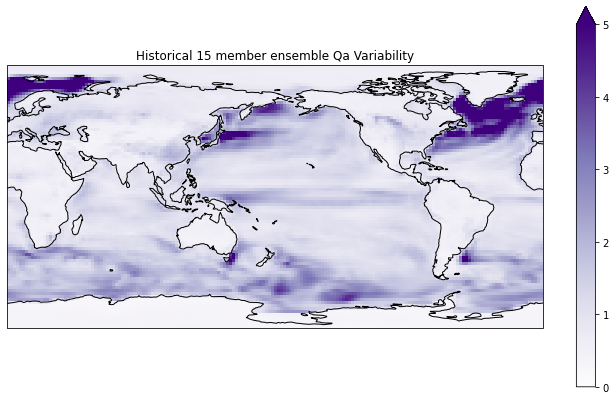

In [61]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
horiz_hist_var.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=5, cmap='Purples')
ax.coastlines(color='black', linewidth=1)
plt.title('Historical 15 member ensemble Qa Variability')

# Mixed Layer Depth

In [3]:
# TOA Incoming Shortwave Flux

path_mlh_control = cat.loc[(cat['variable_id']=='mlotst') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(37)['path'].to_list()
path_mlh_control
# Not enough data

[]

In [6]:
# Find omega

df_hml_control = df.query("activity_id=='CMIP' & table_id == 'Omon' & variable_id == 'mlotst' & experiment_id == 'piControl'")
df_hml_control = df_hml_control.drop_duplicates('source_id').head(37)
df_hml_control

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9212,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...,NaN,20180701
16244,CMIP,NOAA-GFDL,GFDL-ESM4,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piCo...,NaN,20180701
31863,CMIP,CNRM-CERFACS,CNRM-CM6-1,piControl,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1/...,NaN,20180814
32207,CMIP,NASA-GISS,GISS-E2-1-G,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/pi...,NaN,20180824
40214,CMIP,BCC,BCC-CSM2-MR,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/piContro...,NaN,20181015
42727,CMIP,CNRM-CERFACS,CNRM-ESM2-1,piControl,r1i1p1f2,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181115
45366,CMIP,BCC,BCC-ESM1,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r...,NaN,20181218
45755,CMIP,AWI,AWI-CM-1-1-MR,piControl,r1i1p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/piCont...,NaN,20181218
66986,CMIP,IPSL,IPSL-CM6A-LR,piControl,r1i2p1f1,Omon,mlotst,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piCont...,NaN,20190319
67207,CMIP,NCAR,CESM2-WACCM,piControl,r1i1p1f1,Omon,mlotst,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/piContr...,NaN,20190320


In [6]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_hml_control.zstore.values[2]
mapper = gcs.get_mapper(zstore)

test_mlotst = xr.open_zarr(mapper, consolidated=True)
test_mlotst

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

<xarray.Dataset>
Dimensions:      (y: 294, x: 362, nvertex: 4, time: 6000, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    mlotst       (time, y, x) float32 dask.array<chunksize=(468, 294, 362), meta=np.ndarray>
Attributes: (12/57)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-CM6-1_piControl_r1i1p1f2
    activity_id:            CMIP
    arpege_minor_version:   6.3.1
    branch_method:          standard
    ...                     ...
    variant_info:           . Information provided by this attribute may in s...
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/b7279f16-9f7c-4551-8120-25e054ab4ade
    version_id:             v20180814

In [19]:
rolling_ungrid = test_mlotst.mlotst.rolling(time=300,center=True).mean('time')
var_ungrid = rolling_ungrid.std('time')
var_ungrid.load()

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'mlotst' (y: 294, x: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lat      (y, x) float64 -78.79 -78.79 -78.79 -78.79 ... 50.23 50.01 50.01
    lon      (y, x) float64 72.5 73.5 74.5 75.5 76.5 ... 73.05 73.04 73.0 72.99
Dimensions without coordinates: y, x

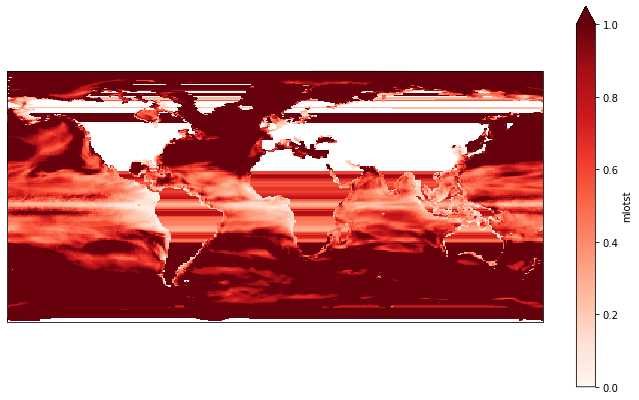

In [26]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
var_ungrid.plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=0,vmax=1, cmap='Reds')

In [7]:
test_mlotst_out = xe.util.grid_global(2,2, lon1=360)
test_mlotst_out

<xarray.Dataset>
Dimensions:  (y: 90, x: 180, y_b: 91, x_b: 181)
Coordinates:
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon_b    (y_b, x_b) float64 0.0 2.0 4.0 6.0 8.0 ... 354.0 356.0 358.0 360.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [8]:
regridder = xe.Regridder(test_mlotst, test_mlotst_out, "bilinear", ignore_degenerate=True)
test_regridded_out = regridder(test_mlotst["mlotst"])
test_regridded_out

<xarray.DataArray (time: 6000, y: 90, x: 180)>
dask.array<_regrid, shape=(6000, 90, 180), dtype=float32, chunksize=(468, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [9]:
test_regridded_out.to_dataset(name='ff')

<xarray.Dataset>
Dimensions:  (time: 6000, y: 90, x: 180)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2349-12-16 12:00:00
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 ... 89.0 89.0 89.0 89.0
    lon      (y, x) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
Dimensions without coordinates: y, x
Data variables:
    ff       (time, y, x) float32 dask.array<chunksize=(468, 90, 180), meta=np.ndarray>

In [13]:
def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]

rolling_test = test_regridded_out.rolling(time=300,center=True).mean('time')
variability_test = rolling_test.std('time')
fin = variability_test.to_dataset(name='mlotst') #Name of variable - mlotst
xin = nc_varget(fin,'lon');
yin = nc_varget(fin,'lat');
zin = nc_varget(fin,'mlotst');

x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

#new coordinates
xout = np.arange(x0,x1+dx,dx)
yout = np.arange(y0,y1+dx,dy)

xm,ym = np.meshgrid(xout,yout)
zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.values.flatten(),(xm,ym), 'nearest')

final_test = xr.DataArray(zo, dims=['lat','lon'])
final_test.coords['lon'] = xout
final_test.coords['lat'] = yout

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


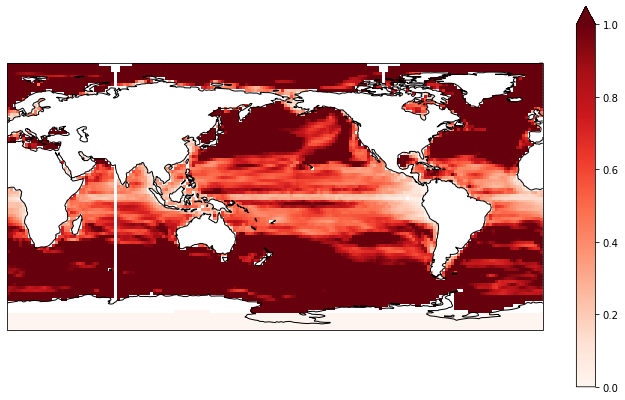

In [25]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
test_var.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)

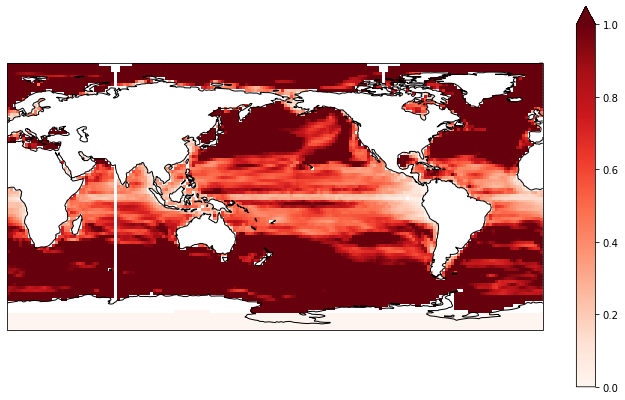

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
final_test.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)

In [15]:
final_test

<xarray.DataArray (lat: 90, lon: 180)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.474138 , 1.4457155, 1.4242212, ..., 1.607038 , 1.55493  ,
        1.5098606],
       [1.5183147, 1.4902302, 1.4622576, ..., 1.6097026, 1.5777199,
        1.54751  ],
       [1.4292563, 1.4108605, 1.3928925, ..., 1.4841306, 1.4659888,
        1.4480423]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0

In [30]:
final_test['lon'].ndim

1

In [26]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_hml_control.zstore.values[0]
mapper = gcs.get_mapper(zstore)

test_mlotst2 = xr.open_zarr(mapper, consolidated=True)
test_mlotst2

<xarray.Dataset>
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 6000)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    mlotst     (time, lat, lon) float32 dask.array<chunksize=(670, 180, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    ...                     ...
    variable_id:            mlotst
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/d9acf7e3-3970-44c5-bb0d-57ec2bc0c5ad...
    version_id:             v20180701

In [3]:
# From Ryan Abernathy's tutorial - Way 2
# Regridding advice: https://stackoverflow.com/questions/71616481/converting-from-2d-lat-lon-matrix-into-1d-lat-lon-array
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
curvi_grid = xe.util.grid_global(2,2, lon1=360)
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

def nc_varget(fin,vin):
    """
    Extract dataset elements
    """
    with fin as f:
        return f.variables[vin][:]
    
dset_list_hml_control = []
for zstore in df_hml_control.zstore.unique():
    name = zstore.split('gs://cmip6/CMIP6')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore), consolidated=True)
    ds_rolling = ds.mlotst.rolling(time=300, center=True).mean('time')
    ds_var = ds_rolling.std('time') 
    if ds['lat'].ndim == 1:
        try:
            ds_interp = ds_var.interp(lat=new_lats, lon=new_lons)
        except:
            pass
    elif ds['lat'].ndim == 2:
        regridder = xe.Regridder(ds_var, curvi_grid, "bilinear", ignore_degenerate=True)
        ds_rectilinear = regridder(ds_var)
        fin = ds_rectilinear.to_dataset(name='mlotst') #Name of variable - mlotst
        xin = nc_varget(fin,'lon');
        yin = nc_varget(fin,'lat');
        zin = nc_varget(fin,'mlotst');

        x0,x1,dx = np.min(xin),np.max(xin),np.abs(np.mean(np.diff(xin)))
        y0,y1,dy = np.min(yin),np.max(yin),np.abs(np.mean(np.diff(yin.T)))

        #new coordinates
        xout = np.arange(x0,x1+dx,dx)
        yout = np.arange(y0,y1+dx,dy)

        xm,ym = np.meshgrid(xout,yout)
        zo = griddata((xin.values.flatten(),yin.values.flatten()),zin.values.flatten(),(xm,ym), 'nearest')

        ds_regrid = xr.DataArray(zo, dims=['lat','lon'])
        ds_regrid.coords['lon'] = xout
        ds_regrid.coords['lat'] = yout
        ds_interp = ds_regrid.interp(lat=new_lats, lon=new_lons)
    dset_list_hml_control.append(ds_interp)

NameError: name 'df_hml_control' is not defined

In [36]:
dset_list_hml_control

[<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
 dask.array<dask_aware_interpnd, shape=(88, 179), dtype=float32, chunksize=(88, 179), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
   * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357,
 <xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
 dask.array<dask_aware_interpnd, shape=(88, 179), dtype=float32, chunksize=(88, 179), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
   * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357,
 <xarray.DataArray (lat: 88, lon: 179)>
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
  

In [37]:
test_hml_control_ds = xr.concat(dset_list_hml_control, dim='name', coords='minimal', compat='override')
control_hml_test = test_hml_control_ds.mean('name')
control_hml_test.load()

/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'mlotst' (lat: 88, lon: 179)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.81748616, 1.75880403, 1.76568958, ..., 2.31116948, 2.20852958,
        2.07267268],
       [1.76620979, 1.82313759, 1.94454538, ..., 1.89451852, 1.80844404,
        1.74998385],
       [3.44004033, 3.48039912, 3.48021962, ..., 3.11461802, 3.2288693 ,
        3.29381019]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

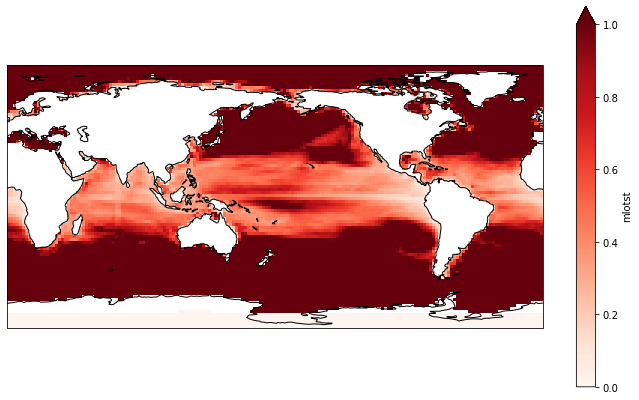

In [43]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_hml_test.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)